---
title: 'Calor extremo: Pergamino, Provincia de Buenos Aires'
author: Nissim Lebovits
date: 26-11-2025
---

## Overview

## Context

In [ ]:
import planetary_computer
import pystac_client
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster
from odc.stac import configure_rio, stac_load

import geopandas as gpd

from pathlib import Path
import requests


from io import BytesIO
from owslib.wfs import WebFeatureService
import pandas as pd
import duckdb
from dask.diagnostics import ProgressBar
import rioxarray as rio
import geopandas as gpd
from pathlib import Path
import requests
from io import BytesIO
import os
import planetary_computer
import pystac_client
from dask.distributed import Client, LocalCluster
from odc.stac import configure_rio, stac_load
import rioxarray as rio
from dask.diagnostics import ProgressBar
import folium
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import base64
import xarray as xr
from rasterio.features import rasterize
import rasterio.enums
import os



import duckdb
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'


USE_CRS = "EPSG:5347"
CRS_WGS84 = "EPSG:4326"

RUTA_DATOS = Path("/home/nissim/Documents/dev/datos-escala-humana/es/cookbooks")

In [2]:
base_url = "https://wms.ign.gob.ar/geoserver/ign/ows"

if (RUTA_DATOS / "municipios.geojson").exists():
    munis = gpd.read_file(RUTA_DATOS / "municipios.geojson")
else:
    params = {
        "service": "WFS",
        "version": "2.0.0",
        "request": "GetFeature",
        "typename": "ign:municipio",
        "outputFormat": "application/json",
        "srsname": "EPSG:4326",
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        munis = gpd.read_file(BytesIO(response.content))
        munis.to_file(RUTA_DATOS / "municipios.geojson", driver="GeoJSON")
    else:
        print(f"Error: {response.status_code}")
        print(response.text)

pergamino = munis[munis["nam"] == "Pergamino"]
pergamino = pergamino.to_crs(USE_CRS)

bbox_pergamino_4326 = pergamino.to_crs(CRS_WGS84).total_bounds

In [3]:
wfs_url = "https://ide.pergamino.gob.ar:8443/geoserver/wfs"
layer_name = "publico:aglomerados_urbanos"

bbox_pergamino = pergamino.to_crs("EPSG:4326").total_bounds

params = {
    "service": "WFS",
    "version": "2.0.0",
    "request": "GetFeature",
    "typename": layer_name,
    "outputFormat": "application/json",
    "srsname": "EPSG:4326",
    "bbox": f"{bbox_pergamino[0]},{bbox_pergamino[1]},{bbox_pergamino[2]},{bbox_pergamino[3]},EPSG:4326",
}

response = requests.get(wfs_url, params=params)

if response.status_code == 200:
    aglomerados_urbanos = gpd.read_file(BytesIO(response.content))

    aglomerados_urbanos = aglomerados_urbanos.to_crs(pergamino.crs)

else:
    print(f"Error: {response.status_code}")
    print(response.text)

## Climate projections

In [25]:
import cdsapi
import xarray as xr
import pandas as pd
import zipfile
import os
from pathlib import Path
import warnings

# Suppress xarray SerializationWarning about multiple fill values
warnings.filterwarnings('ignore', category=xr.SerializationWarning)

# Define experiments to download
experiments = {
    'historical': {'experiment': 'historical', 'period': None},
    'ssp1_2_6': {'experiment': 'ssp1_2_6', 'period': '2015-2100'},
    'ssp2_4_5': {'experiment': 'ssp2_4_5', 'period': '2015-2100'},
    'ssp5_8_5': {'experiment': 'ssp5_8_5', 'period': '2015-2100'},
}

c = cdsapi.Client()
bbox = bbox_pergamino_4326
center_lon = (bbox[0] + bbox[2]) / 2
center_lat = (bbox[1] + bbox[3]) / 2

# Dictionary to store processed data
all_data = {}

for exp_name, exp_config in experiments.items():
    zip_file = f"ipcc_atlas_{exp_name}.zip"
    extract_dir = f"ipcc_{exp_name}_data"
    
    # Download if not exists
    if not Path(zip_file).exists():
        try:
            request = {
                "origin": "cmip6",
                "experiment": exp_config['experiment'],
                "domain": "global",
                "variable": "monthly_count_of_days_with_maximum_temperature_above_35_c",
            }
            if exp_config['period']:
                request['period'] = exp_config['period']
            
            c.retrieve("projections-climate-atlas", request, zip_file)
        except Exception as e:
            print(f"Error downloading {exp_name}: {e}")
            continue
    
    # Extract and process
    try:
        if not Path(extract_dir).exists():
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)
        
        nc_files = [f for f in os.listdir(extract_dir) if f.endswith('.nc')]
        actual_nc_file = os.path.join(extract_dir, nc_files[0])
        
        # Load and subset
        ds = xr.open_dataset(actual_nc_file)
        ds_subset = ds.sel(lon=center_lon, lat=center_lat, method='nearest')
        tx35_mean = ds_subset['tx35'].mean(dim='member')
        
        # Convert to annual data
        df = tx35_mean.to_dataframe().reset_index()
        df['year'] = df['time'].dt.year
        annual_days = df.groupby('year')['tx35'].sum().reset_index()
        annual_days.columns = ['year', 'days_over_35C']
        
        all_data[exp_name] = annual_days
    except Exception as e:
        print(f"Error processing {exp_name}: {e}")
        continue

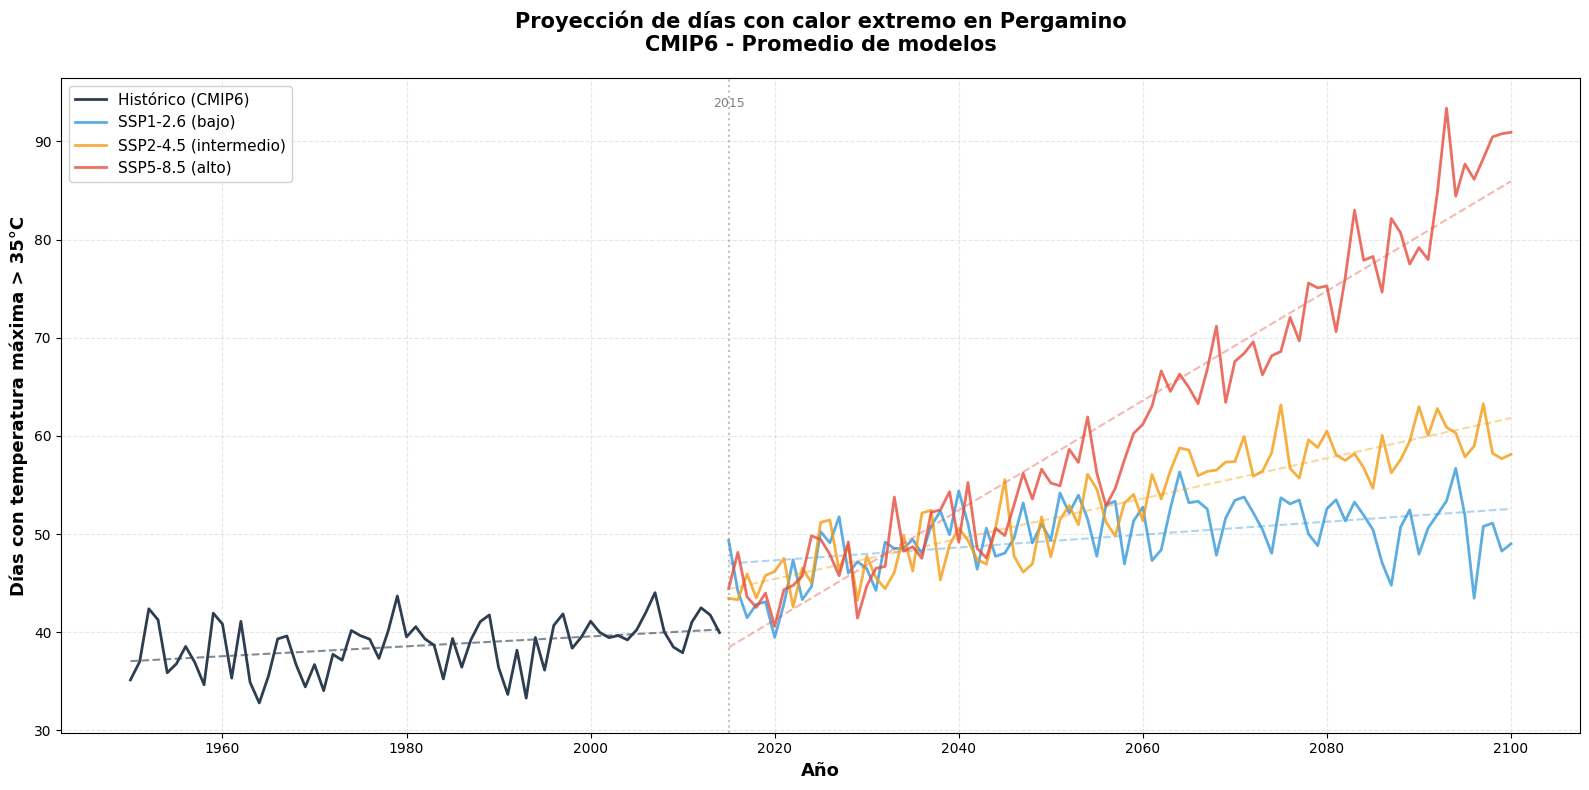

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Filter historical to 1950+
historical_1950 = all_data['historical'][all_data['historical']['year'] >= 1950].copy()

# Create plot
fig, ax = plt.subplots(figsize=(16, 8))

# Define colors for scenarios
colors = {
    'historical': '#2c3e50',
    'ssp1_2_6': '#3498db',  # Blue - low emissions
    'ssp2_4_5': '#f39c12',  # Orange - middle
    'ssp5_8_5': '#e74c3c',  # Red - high emissions
}

labels = {
    'historical': 'Histórico (CMIP6)',
    'ssp1_2_6': 'SSP1-2.6 (bajo)',
    'ssp2_4_5': 'SSP2-4.5 (intermedio)',
    'ssp5_8_5': 'SSP5-8.5 (alto)',
}

# Plot historical
ax.plot(historical_1950['year'], historical_1950['days_over_35C'], 
        linewidth=2, color=colors['historical'], label=labels['historical'])

# Add historical trend line
z_hist = np.polyfit(historical_1950['year'], historical_1950['days_over_35C'], 1)
p_hist = np.poly1d(z_hist)
ax.plot(historical_1950['year'], p_hist(historical_1950['year']), 
        "--", linewidth=1.5, color=colors['historical'], alpha=0.6)

# Plot projections
for scenario in ['ssp1_2_6', 'ssp2_4_5', 'ssp5_8_5']:
    data = all_data[scenario]
    ax.plot(data['year'], data['days_over_35C'], 
            linewidth=2, color=colors[scenario], label=labels[scenario], alpha=0.8)
    
    # Add trend line for each scenario
    z = np.polyfit(data['year'], data['days_over_35C'], 1)
    p = np.poly1d(z)
    ax.plot(data['year'], p(data['year']), 
            "--", linewidth=1.5, color=colors[scenario], alpha=0.4)

# Styling
ax.set_xlabel('Año', fontsize=13, fontweight='bold')
ax.set_ylabel('Días con temperatura máxima > 35°C', fontsize=13, fontweight='bold')
ax.set_title('Proyección de días con calor extremo en Pergamino\nCMIP6 - Promedio de modelos', 
             fontsize=15, fontweight='bold', pad=20)
ax.grid(alpha=0.3, linestyle='--')
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)

# Add vertical line at 2015 to mark transition
ax.axvline(x=2015, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
ax.text(2015, ax.get_ylim()[1] * 0.98, '2015', 
        ha='center', va='top', fontsize=9, color='gray')

plt.tight_layout()
# plt.savefig('dias_calor_extremo_pergamino_time_series.svg', format='svg', bbox_inches='tight')
plt.show()

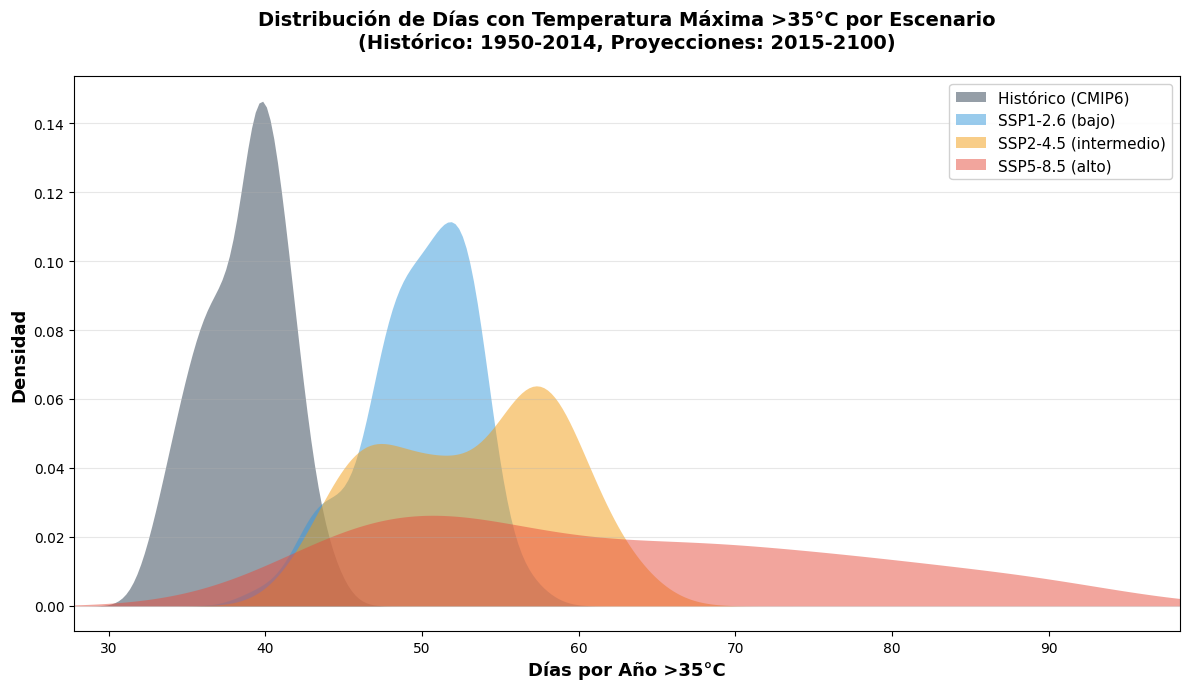

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Create density plot
fig, ax = plt.subplots(figsize=(12, 7))

# Get all data to determine common range
historical_data = all_data['historical'][all_data['historical']['year'] >= 1950]['days_over_35C']
all_values = np.concatenate([
    historical_data.values,
    all_data['ssp1_2_6']['days_over_35C'].values,
    all_data['ssp2_4_5']['days_over_35C'].values,
    all_data['ssp5_8_5']['days_over_35C'].values
])

# Create common x-axis with some padding
x_min = all_values.min() - 5
x_max = all_values.max() + 5
xs = np.linspace(x_min, x_max, 300)

# Plot densities with fill only, no edges
density_hist = stats.gaussian_kde(historical_data)
ax.fill_between(xs, density_hist(xs), alpha=0.5, color=colors['historical'], 
                 label=labels['historical'], linewidth=0)

for scenario in ['ssp1_2_6', 'ssp2_4_5', 'ssp5_8_5']:
    data = all_data[scenario]['days_over_35C']
    density = stats.gaussian_kde(data)
    ax.fill_between(xs, density(xs), alpha=0.5, color=colors[scenario], 
                     label=labels[scenario], linewidth=0)

# Styling
ax.set_xlabel('Días por Año >35°C', fontsize=13, fontweight='bold')
ax.set_ylabel('Densidad', fontsize=13, fontweight='bold')
ax.set_title('Distribución de Días con Temperatura Máxima >35°C por Escenario\n(Histórico: 1950-2014, Proyecciones: 2015-2100)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(axis='y', alpha=0.3)
ax.set_xlim(x_min, x_max)

plt.tight_layout()
# plt.savefig('dias_calor_extremo_pergamino_density.svg', format='svg', bbox_inches='tight')
plt.show()

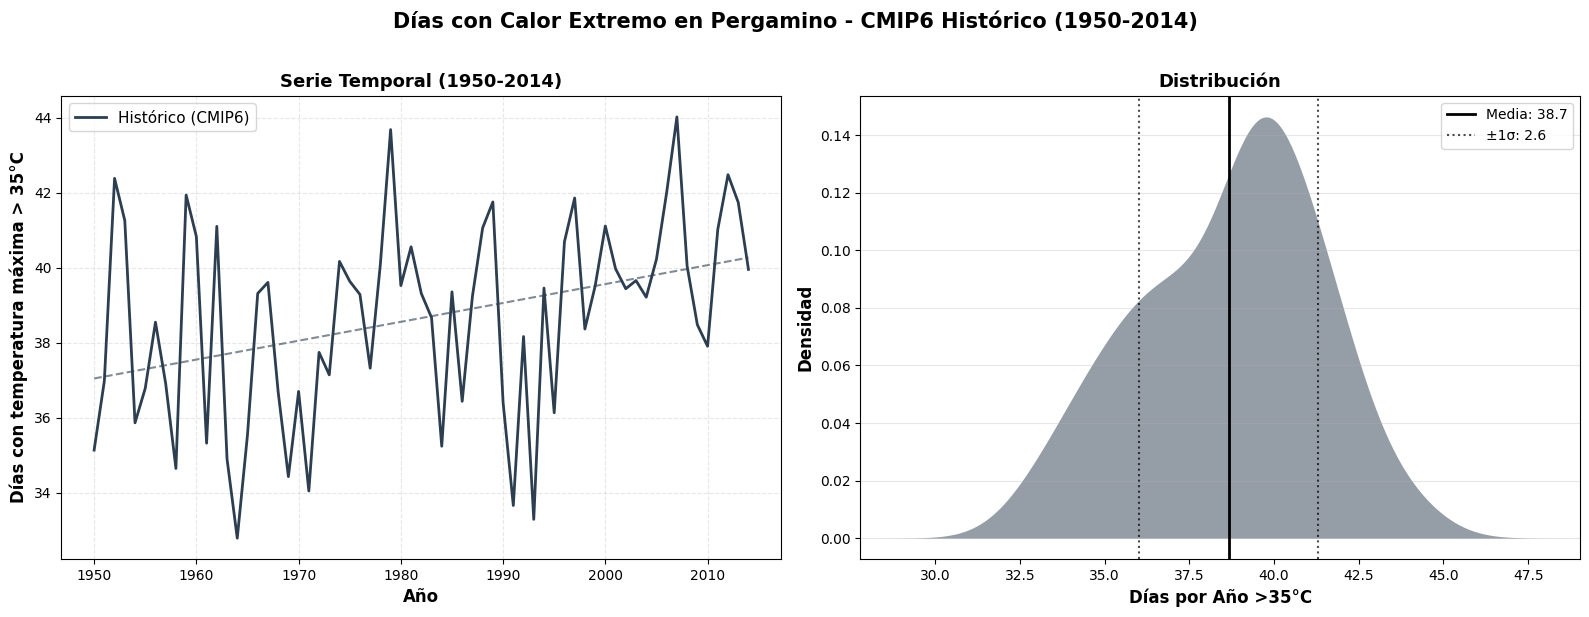

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Filter historical to 1950+
historical_1950 = all_data['historical'][all_data['historical']['year'] >= 1950].copy()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# LEFT PANEL: Time series
ax1.plot(historical_1950['year'], historical_1950['days_over_35C'], 
         linewidth=2, color=colors['historical'], label=labels['historical'])

# Add trend line
z_hist = np.polyfit(historical_1950['year'], historical_1950['days_over_35C'], 1)
p_hist = np.poly1d(z_hist)
ax1.plot(historical_1950['year'], p_hist(historical_1950['year']), 
         "--", linewidth=1.5, color=colors['historical'], alpha=0.6)

ax1.set_xlabel('Año', fontsize=12, fontweight='bold')
ax1.set_ylabel('Días con temperatura máxima > 35°C', fontsize=12, fontweight='bold')
ax1.set_title('Serie Temporal (1950-2014)', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3, linestyle='--')
ax1.legend(fontsize=11)

# RIGHT PANEL: Density plot
historical_data = historical_1950['days_over_35C']
density = stats.gaussian_kde(historical_data)

mean_val = historical_data.mean()
std_val = historical_data.std()

x_min = historical_data.min() - 5
x_max = historical_data.max() + 5
xs = np.linspace(x_min, x_max, 300)

ax2.fill_between(xs, density(xs), alpha=0.5, color=colors['historical'], linewidth=0)

# Add mean line
ax2.axvline(mean_val, color='black', linestyle='-', linewidth=2, label=f'Media: {mean_val:.1f}')

# Add std dev lines
ax2.axvline(mean_val - std_val, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
ax2.axvline(mean_val + std_val, color='black', linestyle=':', linewidth=1.5, alpha=0.7, 
            label=f'±1σ: {std_val:.1f}')

ax2.set_xlabel('Días por Año >35°C', fontsize=12, fontweight='bold')
ax2.set_ylabel('Densidad', fontsize=12, fontweight='bold')
ax2.set_title('Distribución', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_xlim(x_min, x_max)
ax2.legend(fontsize=10)

# Overall title
fig.suptitle('Días con Calor Extremo en Pergamino - CMIP6 Histórico (1950-2014)', 
             fontsize=15, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

In [39]:
mean_val = historical_data.mean()
std_val = historical_data.std()

within_1std = historical_data[(historical_data >= mean_val - std_val) & 
                              (historical_data <= mean_val + std_val)]
pct_within_1std = (len(within_1std) / len(historical_data)) * 100

print(f"Actual % within ±1σ: {pct_within_1std:.1f}%")

Actual % within ±1σ: 67.7%


In [40]:
# Calculate historical baseline (1950-2014)
hist_baseline = all_data['historical'][all_data['historical']['year'] >= 1950]['days_over_35C'].mean()

# Build results dataframe
results = []

for scenario in ['ssp1_2_6', 'ssp2_4_5', 'ssp5_8_5']:
    # Near-term (2020-2050)
    near_term = all_data[scenario][(all_data[scenario]['year'] >= 2020) & 
                                    (all_data[scenario]['year'] <= 2050)]
    near_avg = near_term['days_over_35C'].mean()
    near_increase = near_avg - hist_baseline
    near_pct = (near_increase / hist_baseline) * 100
    
    # Mid-century (2050-2070)
    mid = all_data[scenario][(all_data[scenario]['year'] >= 2050) & 
                              (all_data[scenario]['year'] <= 2070)]
    mid_avg = mid['days_over_35C'].mean()
    mid_increase = mid_avg - hist_baseline
    mid_pct = (mid_increase / hist_baseline) * 100
    
    # End of century (2070-2100)
    eoc = all_data[scenario][all_data[scenario]['year'] >= 2070]
    eoc_avg = eoc['days_over_35C'].mean()
    eoc_increase = eoc_avg - hist_baseline
    eoc_pct = (eoc_increase / hist_baseline) * 100
    
    results.append({
        'Escenario': labels[scenario],
        '2020-2050 (días/año)': f'{near_avg:.1f}',
        '2020-2050 (cambio)': f'+{near_increase:.1f} ({near_pct:+.0f}%)',
        '2050-2070 (días/año)': f'{mid_avg:.1f}',
        '2050-2070 (cambio)': f'+{mid_increase:.1f} ({mid_pct:+.0f}%)',
        '2070-2100 (días/año)': f'{eoc_avg:.1f}',
        '2070-2100 (cambio)': f'+{eoc_increase:.1f} ({eoc_pct:+.0f}%)'
    })

df_projections = pd.DataFrame(results)

print(f"Línea base histórica (1950-2014): {hist_baseline:.1f} días/año\n")
print(df_projections.to_string(index=False))

Línea base histórica (1950-2014): 38.7 días/año

            Escenario 2020-2050 (días/año) 2020-2050 (cambio) 2050-2070 (días/año) 2050-2070 (cambio) 2070-2100 (días/año) 2070-2100 (cambio)
      SSP1-2.6 (bajo)                 48.4        +9.7 (+25%)                 51.6       +12.9 (+33%)                 51.0       +12.3 (+32%)
SSP2-4.5 (intermedio)                 48.0        +9.3 (+24%)                 54.3       +15.6 (+40%)                 58.8       +20.1 (+52%)
      SSP5-8.5 (alto)                 49.3       +10.7 (+28%)                 61.3       +22.7 (+59%)                 78.4      +39.8 (+103%)


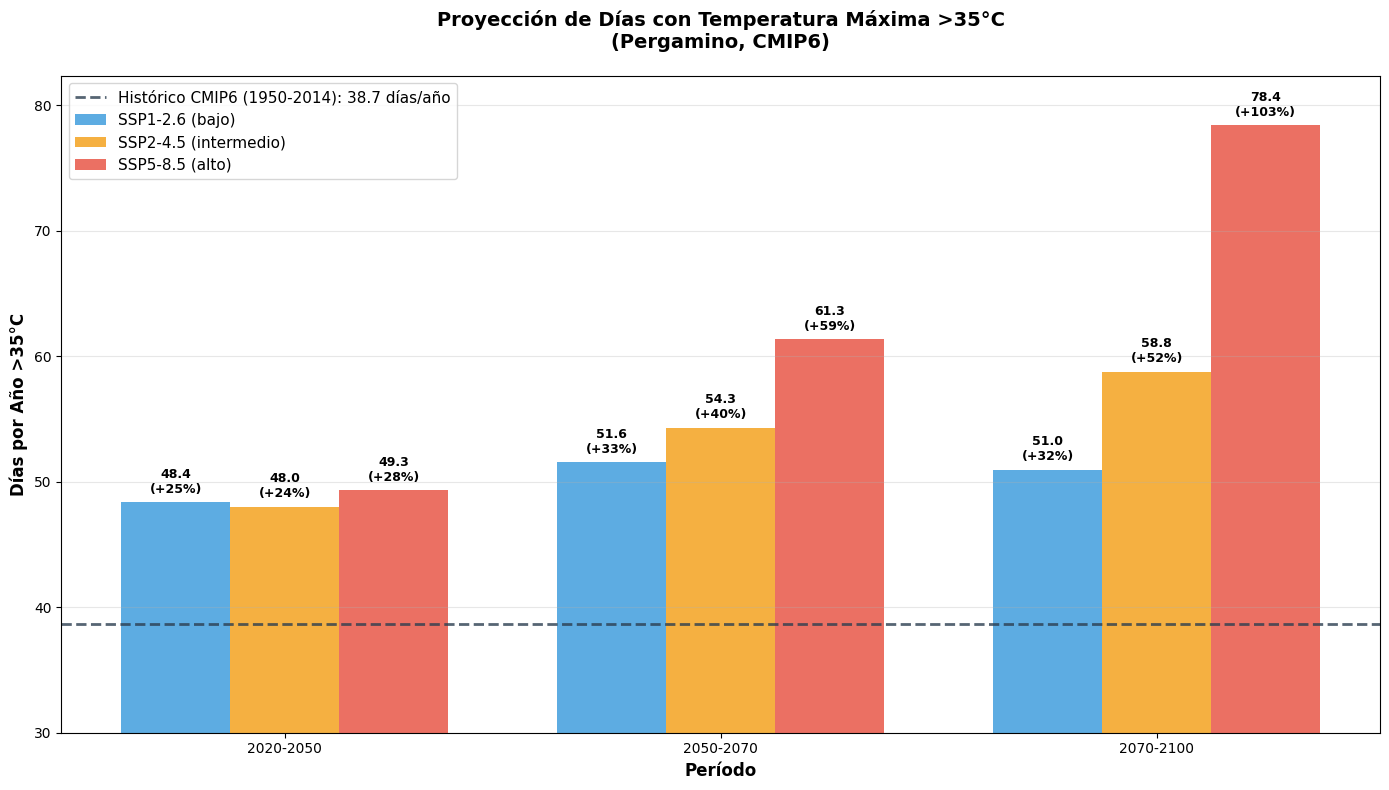

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors and labels
colors = {
    'ssp1_2_6': '#3498db',
    'ssp2_4_5': '#f39c12',
    'ssp5_8_5': '#e74c3c',
}

labels = {
    'ssp1_2_6': 'SSP1-2.6 (bajo)',
    'ssp2_4_5': 'SSP2-4.5 (intermedio)',
    'ssp5_8_5': 'SSP5-8.5 (alto)',
}

# Calculate values for each scenario and time period
time_periods = ['2020-2050', '2050-2070', '2070-2100']

# Future projections for each SSP
data = {
    'ssp1_2_6': [],
    'ssp2_4_5': [],
    'ssp5_8_5': []
}

# Calculate for each SSP scenario
for scenario in ['ssp1_2_6', 'ssp2_4_5', 'ssp5_8_5']:
    # 2020-2050
    period1 = all_data[scenario][(all_data[scenario]['year'] >= 2020) & 
                                  (all_data[scenario]['year'] <= 2050)]
    data[scenario].append(period1['days_over_35C'].mean())
    
    # 2050-2070
    period2 = all_data[scenario][(all_data[scenario]['year'] >= 2050) & 
                                  (all_data[scenario]['year'] <= 2070)]
    data[scenario].append(period2['days_over_35C'].mean())
    
    # 2070-2100
    period3 = all_data[scenario][all_data[scenario]['year'] >= 2070]
    data[scenario].append(period3['days_over_35C'].mean())

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(time_periods))
width = 0.25

# Plot bars for each SSP scenario
bars1 = ax.bar(x - width, data['ssp1_2_6'], width, 
               label=labels['ssp1_2_6'], color=colors['ssp1_2_6'], alpha=0.8)
bars2 = ax.bar(x, data['ssp2_4_5'], width, 
               label=labels['ssp2_4_5'], color=colors['ssp2_4_5'], alpha=0.8)
bars3 = ax.bar(x + width, data['ssp5_8_5'], width, 
               label=labels['ssp5_8_5'], color=colors['ssp5_8_5'], alpha=0.8)

# Add historical baseline as horizontal line
ax.axhline(y=hist_baseline, color='#2c3e50', linestyle='--', linewidth=2, 
           label=f'Histórico CMIP6 (1950-2014): {hist_baseline:.1f} días/año', alpha=0.8)

# Add value labels on bars with percentage increase
for bars, scenario_data in zip([bars1, bars2, bars3], 
                                [data['ssp1_2_6'], data['ssp2_4_5'], data['ssp5_8_5']]):
    for bar, value in zip(bars, scenario_data):
        height = bar.get_height()
        pct_increase = ((value - hist_baseline) / hist_baseline) * 100
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}\n(+{pct_increase:.0f}%)',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Formatting
ax.set_xlabel('Período', fontsize=12, fontweight='bold')
ax.set_ylabel('Días por Año >35°C', fontsize=12, fontweight='bold')
ax.set_title('Proyección de Días con Temperatura Máxima >35°C\n(Pergamino, CMIP6)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(time_periods)
ax.set_ylim(30, None)
ax.legend(loc='upper left', fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
# plt.savefig('dias_calor_extremo_pergamino_bar.svg', format='svg', bbox_inches='tight')
plt.show()

## Exploratory analysis

### Descriptive stats for LST

In [42]:
# Connect to Planetary Computer
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

cluster = LocalCluster(
    processes=True,  # Critical: use processes, not threads
    n_workers=8,  # Use half your cores for workers
    threads_per_worker=2,  # 2 threads per worker = 16 total
    memory_limit="6GB",  # 8 workers × 6GB = 48GB, leaves headroom
    dashboard_address=":0",  # Auto-select an available port
)
client = Client(cluster)
# print(f"Dask dashboard: {client.dashboard_link}")
configure_rio(cloud_defaults=True, client=client)

# Query for last 5 years
bbox = bbox_pergamino_4326
datetime = "2020-01-01/2025-01-01"  # Last 5 years
cloudy_less_than = 20  # You might need to be less strict for 5 years of data

query = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox,
    datetime=datetime,
    query={"eo:cloud_cover": {"lt": cloudy_less_than}},
)

items = list(query.items())
# print(f"Found: {len(items):d} datasets")

In [43]:
# Define output file path (same directory as notebook)
notebook_dir = Path(os.path.dirname(os.path.abspath("pergamino.ipynb")))
lst_tif_path = notebook_dir / "LST_max_pergamino.tif"

# Check if file exists, otherwise compute
if lst_tif_path.exists():
    print(f"Loading existing LST data from {lst_tif_path}")
    LST_max_computed = rio.open_rasterio(lst_tif_path)
    # Squeeze out any extra dimensions if needed
    if len(LST_max_computed.dims) > 2:
        LST_max_computed = LST_max_computed.squeeze()
else:
    print("Computing LST from scratch...")
    # Load only thermal band and QA band
    crs = "epsg:3857"
    yy = stac_load(
        items,
        bands=("lwir11", "qa_pixel"),
        crs=crs,
        resolution=30,
        chunks={"time": 10},  # Process in chunks of 10 time steps
        groupby="landsat:scene_id",
        bbox=bbox_pergamino_4326,
    )

    # Create cloud mask function
    def create_cloud_mask(qa_band):
        """Mask clouds and cloud shadows"""
        # Bit 3: Cloud, Bit 4: Cloud Shadow
        cloud_mask = (qa_band & 0b11000) == 0
        return cloud_mask

    # Apply cloud mask
    yy_masked = yy.where(create_cloud_mask(yy.qa_pixel))

    # Convert thermal band to LST in Celsius
    LST_kelvin = yy_masked["lwir11"] * 0.00341802 + 149.0
    LST_celsius = LST_kelvin - 273.15

    # Calculate maximum LST per pixel over all time steps
    LST_max = LST_celsius.max(dim="time")

    # Before compute()
    print("Computing maximum LST...")
    print(f"Dashboard: {client.dashboard_link}")
    with ProgressBar():
        LST_max_computed = LST_max.compute()

    # Save to file
    print(f"Saving LST data to {lst_tif_path}")
    LST_max_computed.rio.to_raster(lst_tif_path)

Loading existing LST data from /home/nissim/Documents/dev/datos-escala-humana/es/cookbooks/LST_max_pergamino.tif


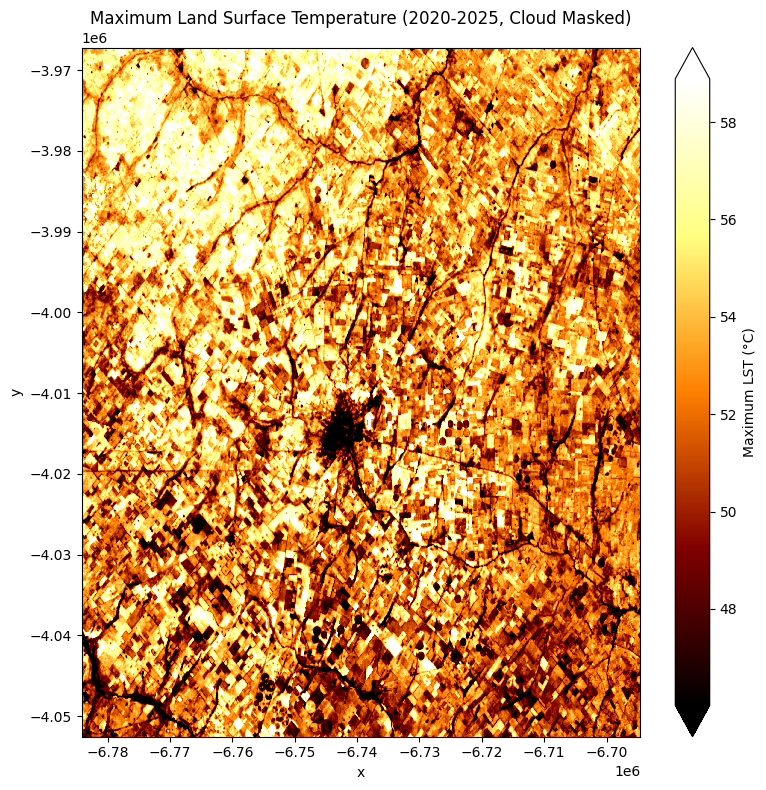

In [44]:
# Plot the result
fig, ax = plt.subplots(figsize=(8, 8))
LST_max_computed.plot.imshow(
    ax=ax,
    cmap="afmhot",
    cbar_kwargs={"label": "Maximum LST (°C)"},
    robust=True,  # Use 2nd and 98th percentiles for color scaling
)
ax.set_title("Maximum Land Surface Temperature (2020-2025, Cloud Masked)")
plt.tight_layout()
plt.show()

In [45]:
# Optional: Save to file
# LST_max_computed.rio.to_raster(RUTA_DATOS / "LST_max_5years.tif")

# Print some statistics
print("\nMaximum LST Statistics:")
print(f"  Overall max: {float(LST_max_computed.max().values):.2f}°C")
print(f"  Overall min: {float(LST_max_computed.min().values):.2f}°C")
print(f"  Mean of maximums: {float(LST_max_computed.mean().values):.2f}°C")
print(f"  Median of maximums: {float(LST_max_computed.median().values):.2f}°C")


Maximum LST Statistics:
  Overall max: 65.36°C
  Overall min: 33.75°C
  Mean of maximums: 52.91°C
  Median of maximums: 52.91°C


### LST by land cover class

In [46]:
# Load the cloud GeoTIFF clipped to your GeoDataFrame
suelo_2022_ruta = "https://storage.googleapis.com/mapbiomas-public/initiatives/argentina/collection-1/coverage/argentina_coverage_2022.tif"

# 1. Use your existing Dask cluster for parallel reads
suelo_2022 = rio.open_rasterio(
    suelo_2022_ruta,
    chunks={"x": 2048, "y": 2048},  # Larger chunks = fewer tasks, faster
    lock=False,  # Critical: allows parallel HTTP reads from GCS
)

# For the clip/compute operation
with ProgressBar():
    # 2. Clip efficiently
    suelo_2022 = suelo_2022.rio.clip(
        pergamino.geometry.values,
        pergamino.crs,
        from_disk=True,
        all_touched=False,  # Only pixels with centers inside
    )

In [47]:
# Define the detailed categories and colors
categories_detailed = {
    "Leñosa cerrada": {"ids": [3], "color": "#1f8d49"},
    "Leñosa abierta": {"ids": [4], "color": "#7dc975"},
    "Leñosa dispersa": {"ids": [45], "color": "#807a40"},
    "Leñosa inundable": {"ids": [6], "color": "#026975"},
    "Vegetación no leñosa inundable": {"ids": [11], "color": "#519799"},
    "Pastizal": {"ids": [12], "color": "#d6bc74"},
    "Estepa": {"ids": [63], "color": "#ebf8b5"},
    "Pastura": {"ids": [15], "color": "#edde8e"},
    "Agricultura": {"ids": [18], "color": "#e974ed"},
    "Plantación forestal": {"ids": [9], "color": "#7a5900"},
    "Cultivo arbustivo": {"ids": [36], "color": "#d082de"},
    "Mosaico agropecuario": {"ids": [21], "color": "#ffefc3"},
    "Área sin vegetación": {"ids": [22], "color": "#d4271e"},
    "Río, lago u océano": {"ids": [33], "color": "#2532e4"},
    "Hielo y nieve en superficie": {"ids": [34], "color": "#93dfe6"},
    "No observado": {"ids": [27], "color": "#ffffff"},
}

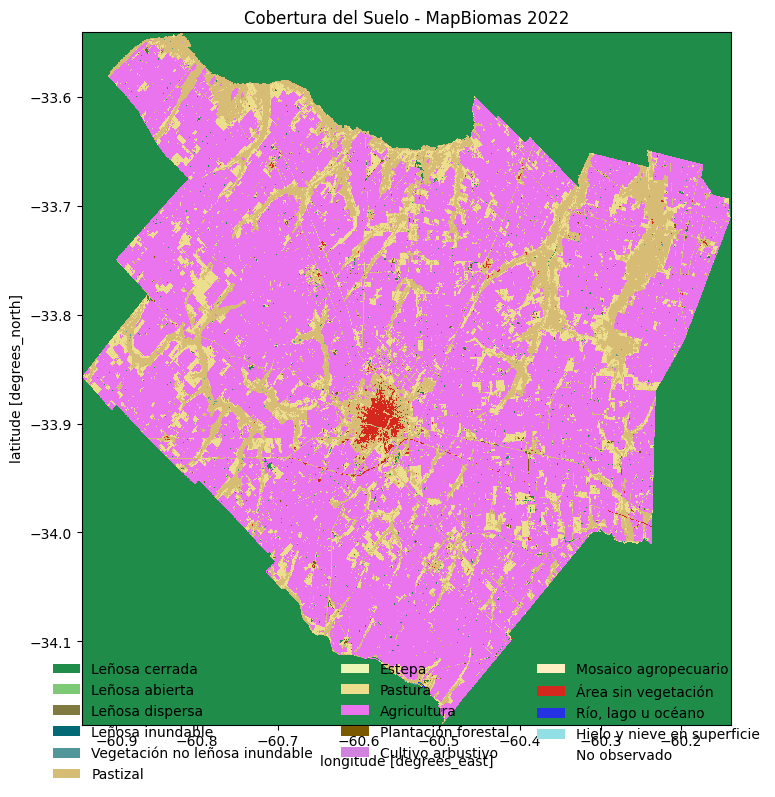

In [48]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create colormap from detailed categories
colors = {}
for category, info in categories_detailed.items():
    for pixel_id in info["ids"]:
        colors[pixel_id] = info["color"]

cmap = mcolors.ListedColormap([colors[i] for i in sorted(colors.keys())])
bounds = sorted(colors.keys())
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the raster
im = suelo_2022.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

# Create custom legend from detailed categories
legend_labels = {}
for category, info in categories_detailed.items():
    legend_labels[info["color"]] = category

# Add legend below the map
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor=color, label=label)
    for color, label in legend_labels.items()
]
ax.legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    frameon=False,
)

plt.title("Cobertura del Suelo - MapBiomas 2022")
plt.tight_layout()
plt.show()

In [49]:
# 1. Reproject land cover to match LST grid (if needed)
suelo_aligned = suelo_2022.rio.reproject_match(LST_max_computed)

# 2. Flatten both arrays and create DataFrame
lst_flat = LST_max_computed.values.flatten()
landcover_flat = suelo_aligned.values.flatten()

df = pd.DataFrame({"LST": lst_flat, "LandCover": landcover_flat})

# 3. Filter out invalid values
df_clean = df[
    (df["LandCover"] > 0)  # Remove 0
    & (df["LandCover"] < 255)  # Remove 255
    & (~df["LandCover"].isna())  # Remove NaN
    & (~df["LST"].isna())  # Remove LST NaN
].copy()

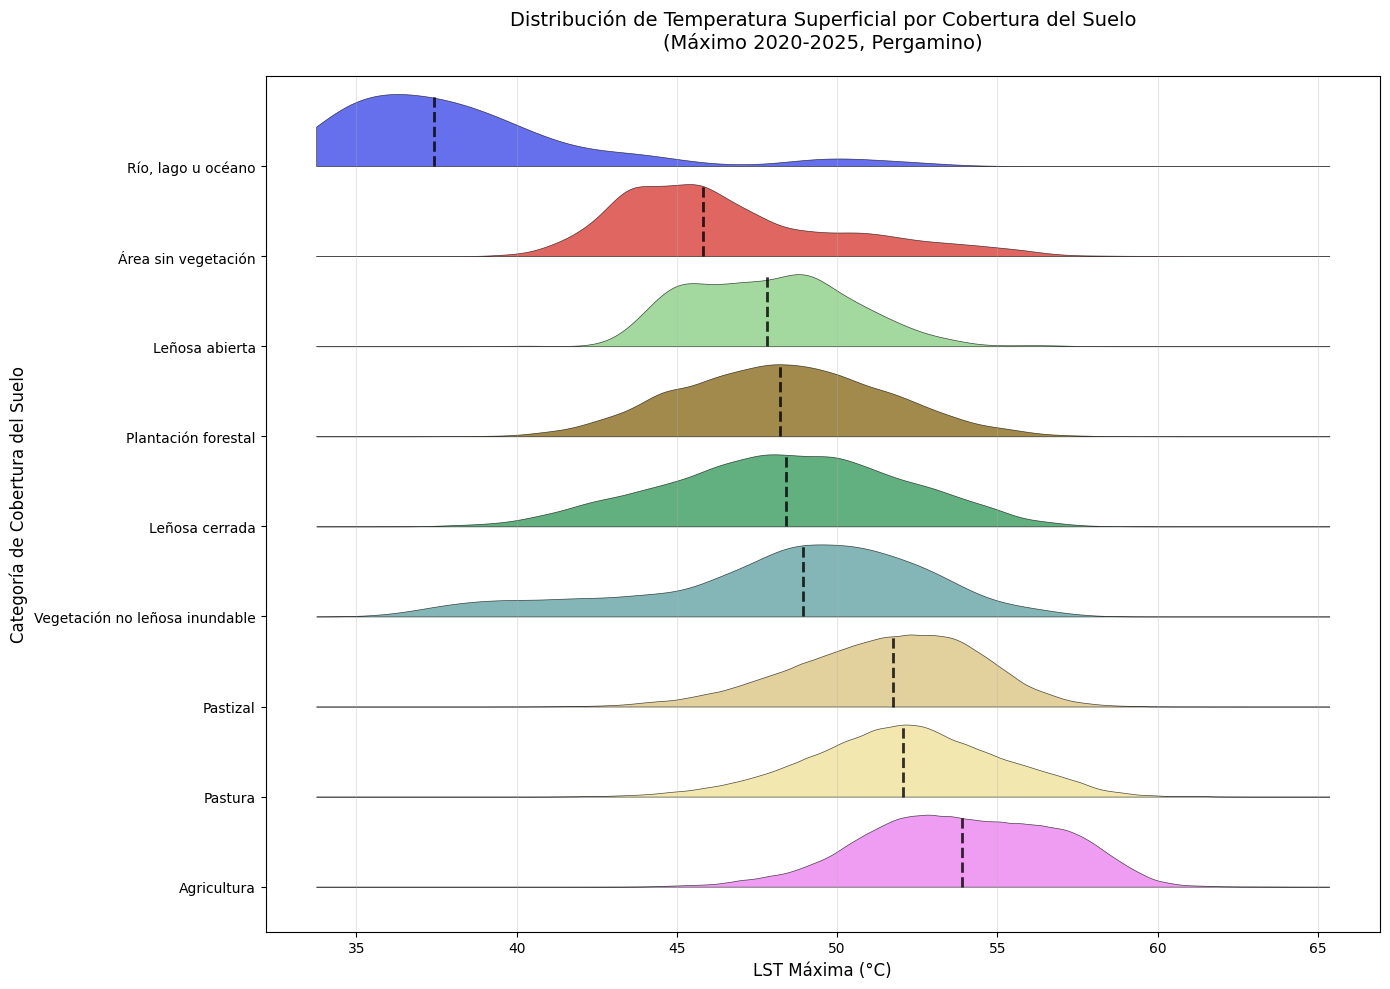

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Create mapping from IDs to category names
id_to_name = {}
for category, details in categories_detailed.items():
    for id_val in details["ids"]:
        id_to_name[id_val] = category

# Add readable names to dataframe
df_clean["Category"] = df_clean["LandCover"].astype(int).map(id_to_name)

# Sort by median LST for better visualization
category_order = (
    df_clean.groupby("Category")["LST"].median().sort_values(ascending=False).index
)

# Create color mapping from categories
category_colors = {cat: details["color"] for cat, details in categories_detailed.items()}

# Create density plots
fig, ax = plt.subplots(figsize=(14, 10))

# Plot density for each category on separate rows
for i, category in enumerate(category_order):
    data = df_clean[df_clean["Category"] == category]["LST"].dropna()
    
    if len(data) > 1:
        # Calculate kernel density estimation
        density = stats.gaussian_kde(data)
        xs = np.linspace(df_clean["LST"].min(), df_clean["LST"].max(), 500)
        density_values = density(xs)
        
        # Normalize and offset density for this row
        density_values = density_values / density_values.max() * 0.8
        
        # Plot density curve starting from row baseline
        ax.fill_between(
            xs,
            i,
            i + density_values,
            alpha=0.7,
            color=category_colors[category],
            edgecolor='black',
            linewidth=0.5
        )
        
        # Add median line
        median_val = data.median()
        ax.plot([median_val, median_val], [i, i + 0.8], 
                color='black', linewidth=2, linestyle='--', alpha=0.8)

ax.set_yticks(range(len(category_order)))
ax.set_yticklabels(category_order)
ax.set_xlabel("LST Máxima (°C)", fontsize=12)
ax.set_ylabel("Categoría de Cobertura del Suelo", fontsize=12)
ax.set_title(
    "Distribución de Temperatura Superficial por Cobertura del Suelo\n(Máximo 2020-2025, Pergamino)",
    fontsize=14,
    pad=20,
)
ax.grid(axis="x", alpha=0.3)
ax.set_ylim(-0.5, len(category_order))
plt.tight_layout()
# plt.savefig('lst_by_landcover_pergamino.svg', format='svg', bbox_inches='tight')
plt.show()

### LST by type of populated area

In [51]:
wfs_url = "https://ide.pergamino.gob.ar:8443/geoserver/wfs"
layer_name = "publico:aglomerados_urbanos"

bbox_pergamino = pergamino.to_crs("EPSG:4326").total_bounds

params = {
    "service": "WFS",
    "version": "2.0.0",
    "request": "GetFeature",
    "typename": layer_name,
    "outputFormat": "application/json",
    "srsname": "EPSG:4326",
    "bbox": f"{bbox_pergamino[0]},{bbox_pergamino[1]},{bbox_pergamino[2]},{bbox_pergamino[3]},EPSG:4326",
}

response = requests.get(wfs_url, params=params)

if response.status_code == 200:
    aglomerados_urbanos = gpd.read_file(BytesIO(response.content))

    aglomerados_urbanos = aglomerados_urbanos.to_crs(pergamino.crs)

else:
    print(f"Error: {response.status_code}")
    print(response.text)

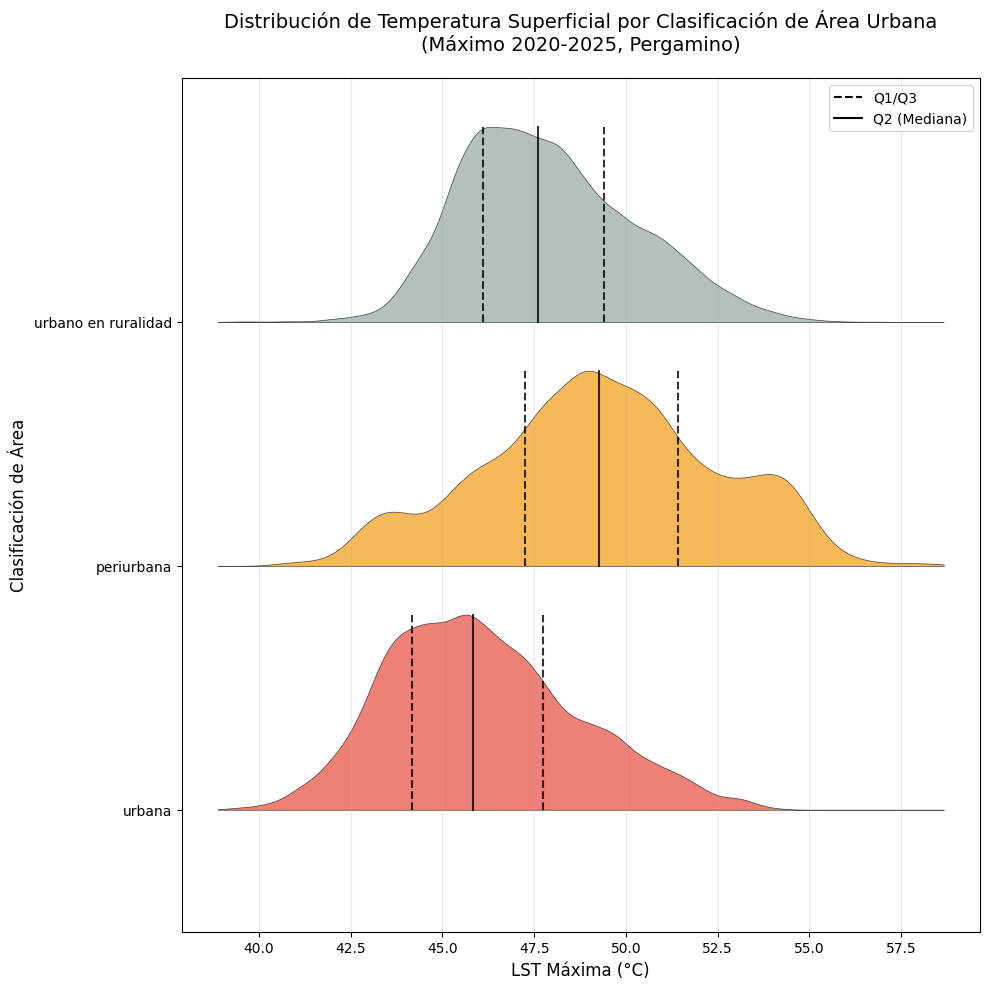


Mean LST by classification:
clasificacion
periurbana             49.311142
urbano en ruralidad    47.873032
urbana                 46.097038
Name: LST, dtype: float32


In [52]:
import pandas as pd
import numpy as np
from rasterio import features
from scipy import stats
import matplotlib.pyplot as plt

# 1. Rasterize the urban classifications to match LST grid
aglomerados_aligned = aglomerados_urbanos.to_crs(LST_max_computed.rio.crs)

# Map classifications to numeric codes
clasificacion_to_code = {
    'urbana': 1,
    'periurbana': 2,
    'urbano en ruralidad': 3
}

aglomerados_aligned['code'] = aglomerados_aligned['clasificacion'].map(clasificacion_to_code)

# Rasterize classifications
transform = LST_max_computed.rio.transform()
shape = LST_max_computed.shape

clasificacion_raster = features.rasterize(
    [(geom, code) for geom, code in zip(aglomerados_aligned.geometry, aglomerados_aligned['code'])],
    out_shape=shape,
    transform=transform,
    fill=0,
    dtype='uint8'
)

# 2. Create dataframe with LST values and their classification
clasificacion_flat = clasificacion_raster.flatten()
lst_flat = LST_max_computed.values.flatten()

# Filter to only pixels within a classification zone (code > 0) and valid LST
valid_mask = (clasificacion_flat > 0) & (~np.isnan(lst_flat))

df_lst_class = pd.DataFrame({
    'code': clasificacion_flat[valid_mask],
    'LST': lst_flat[valid_mask]
})

# Map codes back to classification names
code_to_clasificacion = {v: k for k, v in clasificacion_to_code.items()}
df_lst_class['clasificacion'] = df_lst_class['code'].map(code_to_clasificacion)

# 3. Create density plots
# Fixed order for all subplots
clasificacion_order = ['urbana', 'periurbana', 'urbano en ruralidad']

clasificacion_colors = {
    'urbana': '#e74c3c',
    'periurbana': '#f39c12',
    'urbano en ruralidad': '#95a5a6'
}

fig, ax = plt.subplots(figsize=(10, 10))

for i, clasificacion in enumerate(clasificacion_order):
    data = df_lst_class[df_lst_class['clasificacion'] == clasificacion]['LST'].dropna()
    
    if len(data) > 1:
        # Calculate kernel density estimation
        density = stats.gaussian_kde(data)
        xs = np.linspace(df_lst_class['LST'].min(), df_lst_class['LST'].max(), 500)
        density_values = density(xs)
        
        # Normalize and offset density for this row
        density_values = density_values / density_values.max() * 0.8
        
        # Plot density curve starting from row baseline
        ax.fill_between(
            xs,
            i,
            i + density_values,
            alpha=0.7,
            color=clasificacion_colors.get(clasificacion, '#95a5a6'),
            edgecolor='black',
            linewidth=0.5
        )
        
        # Calculate and plot quartiles
        q1 = data.quantile(0.25)
        q2 = data.quantile(0.50)  # median
        q3 = data.quantile(0.75)
        
        # Plot quartile lines
        for q, style in [(q1, '--'), (q2, '-'), (q3, '--')]:
            ax.plot([q, q], [i, i + 0.8], 
                   color='black', 
                   linestyle=style, 
                   linewidth=1.5, 
                   alpha=0.8)

ax.set_yticks(range(len(clasificacion_order)))
ax.set_yticklabels(clasificacion_order)
ax.set_xlabel("LST Máxima (°C)", fontsize=12)
ax.set_ylabel("Clasificación de Área", fontsize=12)
ax.set_title(
    "Distribución de Temperatura Superficial por Clasificación de Área Urbana\n(Máximo 2020-2025, Pergamino)",
    fontsize=14,
    pad=20,
)
ax.grid(axis="x", alpha=0.3)
ax.set_ylim(-0.5, len(clasificacion_order))

# Add legend for quartile lines
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', linestyle='--', linewidth=1.5, label='Q1/Q3'),
    Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, label='Q2 (Mediana)')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
# plt.savefig('lst_by_area_type_pergamino.svg', format='svg', bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nMean LST by classification:")
print(df_lst_class.groupby('clasificacion')['LST'].mean().sort_values(ascending=False))

### LST by tree canopy cover by populated area

In [53]:
import requests
import geopandas as gpd
from rasterio import features
import numpy as np
from scipy import stats

# Load tree canopy data from WFS
arbolado_layer_name = "publico:cobertura_arbolado_urbano"

params = {
    "service": "WFS",
    "version": "2.0.0",
    "request": "GetFeature",
    "typename": arbolado_layer_name,
    "outputFormat": "application/json",
    "srsname": "EPSG:4326",
    "bbox": f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]},EPSG:4326",
}

response = requests.get(wfs_url, params=params)

if response.status_code == 200:
    arbolado_gdf = gpd.read_file(BytesIO(response.content))
    print(f"Loaded {len(arbolado_gdf)} tree features")
    arbolado_gdf = arbolado_gdf.to_crs(pergamino.crs)
else:
    print(f"Error: {response.status_code}")
    print(response.text)

# 1. Align canopy to LST grid
cobertura_aligned = arbolado_gdf.to_crs(LST_max_computed.rio.crs)

# 2. Get grid info from LST
transform = LST_max_computed.rio.transform()
shape = LST_max_computed.shape
pixel_size = abs(float(LST_max_computed.rio.resolution()[0]))
pixel_area = pixel_size**2
print(f"Grid: {shape}, Pixel size: {pixel_size}m, Pixel area: {pixel_area} m²")

# 3. Create empty array for canopy coverage
canopy_coverage = np.zeros(shape, dtype=np.float32)

# 4. Rasterize: sum of intersecting canopy areas per pixel
print("Rasterizing tree canopy...")
upscale = 10
fine_shape = (shape[0] * upscale, shape[1] * upscale)
fine_transform = transform * transform.scale(1 / upscale, 1 / upscale)

# Rasterize canopy as binary mask at fine resolution
fine_mask = features.rasterize(
    shapes=cobertura_aligned.geometry,
    out_shape=fine_shape,
    transform=fine_transform,
    fill=0,
    default_value=1,
    dtype="uint8",
)

# 5. Aggregate to target resolution (percentage coverage)
canopy_percent = (
    fine_mask.reshape(shape[0], upscale, shape[1], upscale).mean(axis=(1, 3)) * 100
)

# 6. Create xarray aligned with LST
canopy_coverage_xr = LST_max_computed.copy()
canopy_coverage_xr.values = canopy_percent
canopy_coverage_xr.name = "canopy_coverage_percent"
print(
    f"Canopy coverage range: {canopy_coverage_xr.min().values:.2f}% - {canopy_coverage_xr.max().values:.2f}%"
)
print(f"Mean coverage: {canopy_coverage_xr.mean().values:.2f}%")

# canopy_coverage_xr.rio.to_raster("canopy_coverage_percent.tif")

Loaded 45825 tree features
Grid: (2845, 2985), Pixel size: 30.0m, Pixel area: 900.0 m²
Rasterizing tree canopy...
Canopy coverage range: 0.00% - 100.00%
Mean coverage: 0.15%



Relación Cobertura Arbórea - LST por Tipo de Área:
      clasificacion  n_pixels  spearman_rho  p_value     slope  intercept  r_squared  mean_canopy  mean_lst
             urbana     42239     -0.263511      0.0 -0.021986  46.431647   0.024638    15.219087 46.097038
         periurbana     17024     -0.425969      0.0 -0.061416  49.900142   0.156576     9.590343 49.311142
urbano en ruralidad     17418     -0.346238      0.0 -0.025103  48.311543   0.065949    17.468079 47.873035


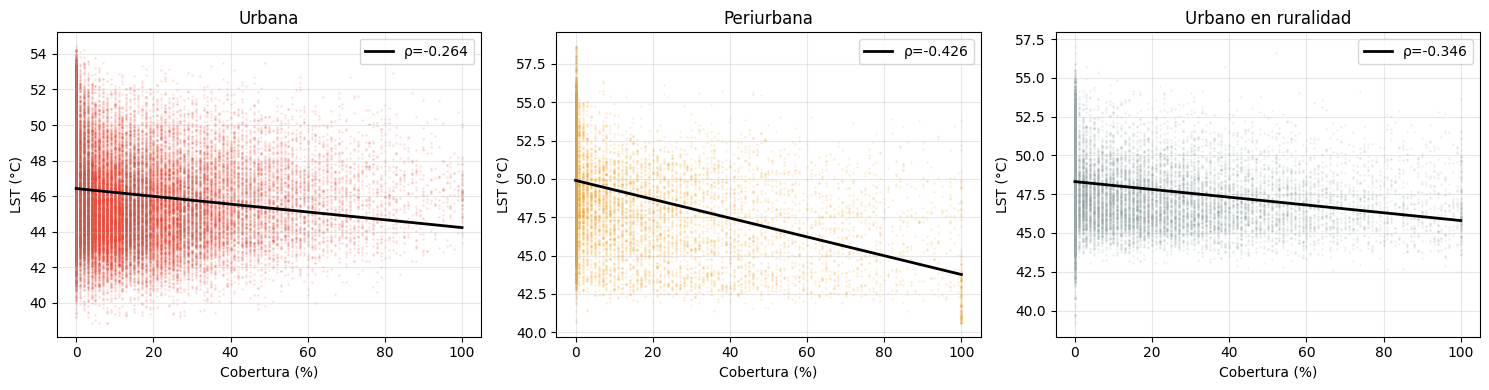

In [54]:
from rasterio import features
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

# Rasterize urban classifications to match LST grid
aglomerados_aligned = aglomerados_urbanos.to_crs(LST_max_computed.rio.crs)

clasificacion_to_code = {
    'urbana': 1,
    'periurbana': 2,
    'urbano en ruralidad': 3
}

aglomerados_aligned['code'] = aglomerados_aligned['clasificacion'].map(clasificacion_to_code)

clasificacion_raster = features.rasterize(
    shapes=((geom, value) for geom, value in zip(aglomerados_aligned.geometry, aglomerados_aligned['code'])),
    out_shape=LST_max_computed.shape,
    transform=LST_max_computed.rio.transform(),
    fill=0,
    dtype='uint8'
)

# Flatten rasters
canopy_flat = canopy_coverage_xr.values.flatten()
lst_flat = LST_max_computed.values.flatten()
clasificacion_flat = clasificacion_raster.flatten()

# Calculate statistics by urban type
results = []
for clasificacion, code in clasificacion_to_code.items():
    mask = (clasificacion_flat == code) & (~np.isnan(lst_flat)) & (~np.isnan(canopy_flat))
    lst_class = lst_flat[mask]
    canopy_class = canopy_flat[mask]
    
    if len(lst_class) > 1:
        rho, p_value = stats.spearmanr(canopy_class, lst_class)
        slope, intercept, r_value, _, _ = stats.linregress(canopy_class, lst_class)
        
        results.append({
            'clasificacion': clasificacion,
            'n_pixels': len(lst_class),
            'spearman_rho': rho,
            'p_value': p_value,
            'slope': slope,
            'intercept': intercept,
            'r_squared': r_value**2,
            'mean_canopy': canopy_class.mean(),
            'mean_lst': lst_class.mean()
        })

df_results = pd.DataFrame(results)
print("\nRelación Cobertura Arbórea - LST por Tipo de Área:")
print(df_results.to_string(index=False))

# Visualization with scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = {'urbana': '#e74c3c', 'periurbana': '#f39c12', 'urbano en ruralidad': '#95a5a6'}

for idx, (clasificacion, code) in enumerate(clasificacion_to_code.items()):
    mask = (clasificacion_flat == code) & (~np.isnan(lst_flat)) & (~np.isnan(canopy_flat))
    canopy = canopy_flat[mask]
    lst = lst_flat[mask]
    
    axes[idx].scatter(
        canopy,
        lst,
        s=1,
        alpha=0.1,
        color=colors[clasificacion],
        rasterized=True
    )
    
    row = df_results[df_results['clasificacion'] == clasificacion].iloc[0]
    x_line = np.array([canopy.min(), canopy.max()])
    y_line = row['slope'] * x_line + row['intercept']
    axes[idx].plot(x_line, y_line, 'k-', linewidth=2, 
                   label=f"ρ={row['spearman_rho']:.3f}")
    
    axes[idx].set_title(clasificacion.capitalize())
    axes[idx].set_xlabel("Cobertura (%)")
    axes[idx].set_ylabel("LST (°C)")
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### LST by distance to water by populated area

In [55]:
wfs_url = "https://ide.pergamino.gob.ar:8443/geoserver/wfs"
layer_name = "publico:cursos_de_agua"

# Build GetFeature request
bbox = pergamino.to_crs("EPSG:4326").total_bounds

params = {
    "service": "WFS",
    "version": "2.0.0",
    "request": "GetFeature",
    "typename": layer_name,
    "outputFormat": "application/json",
    "srsname": "EPSG:4326",
    "bbox": f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]},EPSG:4326",
}

response = requests.get(wfs_url, params=params)

if response.status_code == 200:
    cursos_agua_gdf = gpd.read_file(BytesIO(response.content))
    print(f"Loaded {len(cursos_agua_gdf)} watercourse features")
    print(f"CRS: {cursos_agua_gdf.crs}")

    # Clip to exact Pergamino boundary
    cursos_agua_gdf = cursos_agua_gdf.to_crs(pergamino.crs)

else:
    print(f"Error: {response.status_code}")
    print(response.text)

Loaded 430 watercourse features
CRS: EPSG:4326


In [56]:
from rasterio import features
import numpy as np

# 1. Align watercourses to LST grid
cursos_agua_aligned = cursos_agua_gdf.to_crs(LST_max_computed.rio.crs)

# 2. Get transform and shape from LST raster
transform = LST_max_computed.rio.transform()
shape = LST_max_computed.shape

# 3. Rasterize water features directly
water_mask = features.rasterize(
    shapes=cursos_agua_aligned.geometry,
    out_shape=shape,
    transform=transform,
    fill=0,
    default_value=1,
    dtype="uint8",
)

# 4. Calculate distance transform
from scipy.ndimage import distance_transform_edt

distance_pixels = distance_transform_edt(~water_mask.astype(bool))

# Convert to meters
pixel_size = abs(float(LST_max_computed.rio.resolution()[0]))
distance_meters = distance_pixels * pixel_size

# 5. Create xarray with proper coords
distance_to_water = LST_max_computed.copy()
distance_to_water.values = distance_meters
distance_to_water.name = "distance_to_water"

# distance_to_water.rio.to_raster("distance_to_water.tif")


Relación Distancia al Agua - LST por Tipo de Área:
      clasificacion  n_pixels  spearman_rho      p_value     slope  intercept  r_squared  mean_distance  mean_lst
             urbana     42239      0.281545 0.000000e+00  0.001001  45.004061   0.092419    1092.288722 46.097038
         periurbana     17024      0.384851 0.000000e+00  0.001353  47.664929   0.155751    1216.539712 49.311142
urbano en ruralidad     17418     -0.041872 3.235016e-08 -0.000179  48.143665   0.010205    1510.866101 47.873035


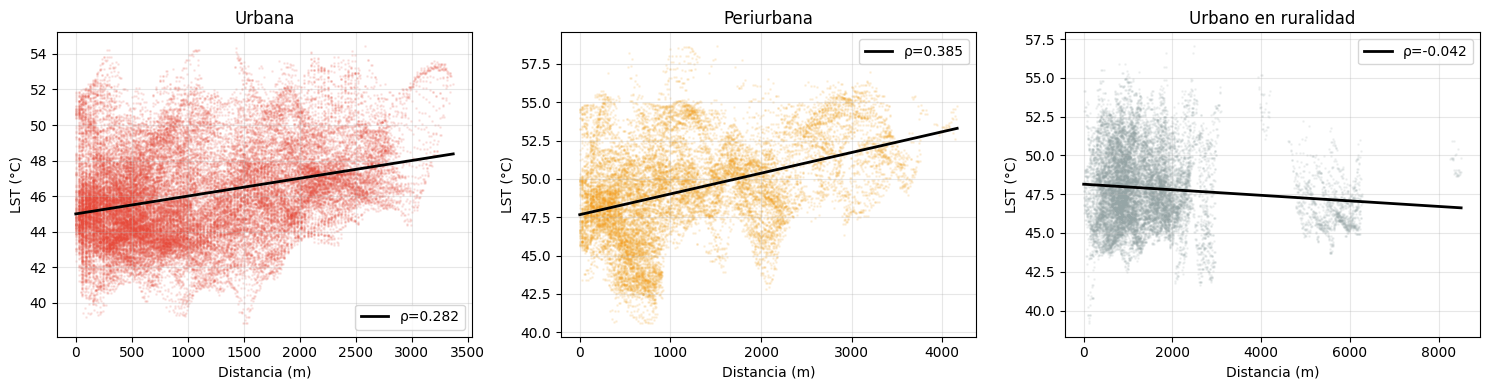

In [57]:
from rasterio import features
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

# Rasterize urban classifications to match LST grid
aglomerados_aligned = aglomerados_urbanos.to_crs(LST_max_computed.rio.crs)

clasificacion_to_code = {
    'urbana': 1,
    'periurbana': 2,
    'urbano en ruralidad': 3
}

aglomerados_aligned['code'] = aglomerados_aligned['clasificacion'].map(clasificacion_to_code)

clasificacion_raster = features.rasterize(
    shapes=((geom, value) for geom, value in zip(aglomerados_aligned.geometry, aglomerados_aligned['code'])),
    out_shape=LST_max_computed.shape,
    transform=LST_max_computed.rio.transform(),
    fill=0,
    dtype='uint8'
)

# Flatten rasters
distance_flat = distance_to_water.values.flatten()
lst_flat = LST_max_computed.values.flatten()
clasificacion_flat = clasificacion_raster.flatten()

# Calculate statistics by urban type
results = []
for clasificacion, code in clasificacion_to_code.items():
    mask = (clasificacion_flat == code) & (~np.isnan(lst_flat)) & (~np.isnan(distance_flat))
    lst_class = lst_flat[mask]
    distance_class = distance_flat[mask]
    
    if len(lst_class) > 1:
        rho, p_value = stats.spearmanr(distance_class, lst_class)
        slope, intercept, r_value, _, _ = stats.linregress(distance_class, lst_class)
        
        results.append({
            'clasificacion': clasificacion,
            'n_pixels': len(lst_class),
            'spearman_rho': rho,
            'p_value': p_value,
            'slope': slope,
            'intercept': intercept,
            'r_squared': r_value**2,
            'mean_distance': distance_class.mean(),
            'mean_lst': lst_class.mean()
        })

df_results = pd.DataFrame(results)
print("\nRelación Distancia al Agua - LST por Tipo de Área:")
print(df_results.to_string(index=False))

# Visualization with scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = {'urbana': '#e74c3c', 'periurbana': '#f39c12', 'urbano en ruralidad': '#95a5a6'}

for idx, (clasificacion, code) in enumerate(clasificacion_to_code.items()):
    mask = (clasificacion_flat == code) & (~np.isnan(lst_flat)) & (~np.isnan(distance_flat))
    distance = distance_flat[mask]
    lst = lst_flat[mask]
    
    axes[idx].scatter(
        distance,
        lst,
        s=1,
        alpha=0.1,
        color=colors[clasificacion],
        rasterized=True
    )
    
    row = df_results[df_results['clasificacion'] == clasificacion].iloc[0]
    x_line = np.array([distance.min(), distance.max()])
    y_line = row['slope'] * x_line + row['intercept']
    axes[idx].plot(x_line, y_line, 'k-', linewidth=2, 
                   label=f"ρ={row['spearman_rho']:.3f}")
    
    axes[idx].set_title(clasificacion.capitalize())
    axes[idx].set_xlabel("Distancia (m)")
    axes[idx].set_ylabel("LST (°C)")
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### LST by building volume by type of area

In [58]:
import math
import geopandas as gpd
import os

import matplotlib.pyplot as plt

import geopandas as gpd


import pandas as pd


WEB_MERCATOR_CRS = "EPSG:3857"

# Your existing AOI geometry
# pergamino = gpd.read_file("pergamino.geojson")  # Example if not already loaded
CRS_WGS84 = "EPSG:4326"

# Output file
EDIFICACIONES_RUTA = "edificaciones_pergamino_gba.parquet"

# 1️⃣ Compute bounding box in WGS84
aoi_bounds = pergamino.to_crs(CRS_WGS84).total_bounds  # [xmin, ymin, xmax, ymax]
xmin, ymin, xmax, ymax = aoi_bounds
print(f"Caja delimitadora de Pergamino: {aoi_bounds}")


# 2️⃣ Compute overlapping 5°×5° tiles
def tile_name(lon_min, lat_min):
    """Return a tile filename component given SW corner (lon_min, lat_min)."""
    ew = "e" if lon_min >= 0 else "w"
    ns = "n" if lat_min >= 0 else "s"
    lon_tag = f"{abs(int(lon_min)):03d}"
    lat_tag = f"{abs(int(lat_min)):02d}"
    return ew + lon_tag + "_" + ns + lat_tag


# Compute all overlapping 5° grid indices
lon_starts = range(
    int(math.floor(xmin / 5.0)) * 5, int(math.ceil(xmax / 5.0)) * 5 + 5, 5
)
lat_starts = range(
    int(math.floor(ymin / 5.0)) * 5, int(math.ceil(ymax / 5.0)) * 5 + 5, 5
)

tiles = []
for lon0 in lon_starts:
    for lat0 in lat_starts:
        lon1 = lon0 + 5
        lat1 = lat0 + 5
        name = f"{tile_name(lon0, lat1)}_{tile_name(lon1, lat0)}.parquet"
        tiles.append(name)

# print("Posibles tiles a usar:")
# for t in tiles:
#     print("  ", t)

# 3️⃣ Base URL for dataset
BASE_URL = "https://data.source.coop/tge-labs/globalbuildingatlas-lod1/"
urls = [BASE_URL + t for t in tiles]

# 4️⃣ Connect to DuckDB
con = duckdb.connect()
for cmd in [
    "INSTALL spatial",
    "LOAD spatial",
    "INSTALL httpfs",
    "LOAD httpfs",
    "SET s3_url_style='path'",
    "SET s3_use_ssl=true",
]:
    con.execute(cmd)

# 5️⃣ Query & filter each tile by AOI bbox
if os.path.exists(EDIFICACIONES_RUTA):
    print("Cargando edificaciones existentes...")
    edificaciones = gpd.read_parquet(EDIFICACIONES_RUTA)
else:
    print("Descargando y filtrando datos de Global Building Atlas (LOD1)...")

    aoi_filter = f"""
    bbox.xmax >= {xmin} AND bbox.xmin <= {xmax} AND
    bbox.ymax >= {ymin} AND bbox.ymin <= {ymax}
    """

    # Combine all matching tiles
    query = f"""
    COPY (
        SELECT id, height, geometry
        FROM read_parquet({urls}, filename=true)
        WHERE {aoi_filter}
    ) TO '{EDIFICACIONES_RUTA}' (FORMAT PARQUET);
    """

    con.execute(query)
    print("Datos guardados localmente como Parquet.")

    # Load into GeoDataFrame
    df = gpd.read_parquet(EDIFICACIONES_RUTA)
    # The geometry column is already shapely Polygon objects
    edificaciones = gpd.GeoDataFrame(df, geometry="geometry", crs=CRS_WGS84)


# 6️⃣ Clip to AOI
edificaciones = edificaciones.to_crs(USE_CRS)
edificaciones = edificaciones[edificaciones.intersects(pergamino.geometry.iloc[0])]
print(f"Total de edificaciones dentro de Pergamino: {len(edificaciones)}")

Caja delimitadora de Pergamino: [-60.942796   -34.17645991 -60.138771   -33.54020044]
Cargando edificaciones existentes...
Total de edificaciones dentro de Pergamino: 116088


In [59]:
from geocube.api.core import make_geocube

# 1. Calculate building volume (footprint area × height)
edificaciones["area"] = edificaciones.geometry.area  # in CRS units (m²)
edificaciones["volume"] = edificaciones["area"] * edificaciones["height"].fillna(0)

# 1. Reproject template to match buildings CRS (meters)
template_projected = LST_max_computed.rio.reproject("EPSG:5347")

# 2. Recalculate areas in proper CRS
edificaciones_aligned = edificaciones.to_crs("EPSG:5347")  # Should already be there
edificaciones_aligned["area"] = edificaciones_aligned.geometry.area
edificaciones_aligned["volume"] = edificaciones_aligned["area"] * edificaciones_aligned[
    "height"
].fillna(0)

# 3. Rasterize using projected template
building_cube = make_geocube(
    vector_data=edificaciones_aligned,
    measurements=["volume"],
    like=template_projected,
    fill=0,
)

# 4. Calculate pixel area in meters (now correct)
pixel_width = abs(float(template_projected.rio.resolution()[0]))
pixel_height = abs(float(template_projected.rio.resolution()[1]))
pixel_area = pixel_width * pixel_height

# print(f"Pixel size: {pixel_width:.2f} × {pixel_height:.2f} m")
# print(f"Pixel area: {pixel_area:.2f} m²")

# 5. Normalize properly
volume_density = building_cube["volume"] / pixel_area

# print(
#     f"Volume density range: {float(volume_density.min()):.2f} - {float(volume_density.max()):.2f} m³/m²"
# )

# volume_density.rio.to_raster("volume_density.tif")

# Get non-zero values for histogram
values = volume_density.values.flatten()
values_nonzero = values[values > 0]



# Additional stats
print("\nEstadísticas:")
print(f"  Media: {values_nonzero.mean():.2f} m³/m²")
print(f"  Mediana: {np.median(values_nonzero):.2f} m³/m²")
print(f"  Desv. Est.: {values_nonzero.std():.2f} m³/m²")
print(f"  Percentil 95: {np.percentile(values_nonzero, 95):.2f} m³/m²")
print(f"  Range: {values_nonzero.min():.2f} - {values_nonzero.max():.2f} m³/m²")


Estadísticas:
  Media: 3.23 m³/m²
  Mediana: 0.62 m³/m²
  Desv. Est.: 12.84 m³/m²
  Percentil 95: 12.37 m³/m²
  Range: 0.00 - 227.59 m³/m²



Relación Densidad Volumétrica - LST por Tipo de Área:
      clasificacion  n_pixels  spearman_rho      p_value    slope  intercept  r_squared  mean_density  mean_lst
             urbana      9639     -0.072539 1.002206e-12 0.035648  44.916545   0.012083      1.924513 44.985149
         periurbana      1126     -0.115310 1.053249e-04 0.000453  47.874733   0.000029     13.279398 47.880749
urbano en ruralidad      1902      0.136128 2.512177e-09 0.029127  47.398619   0.018126      2.930734 47.483982


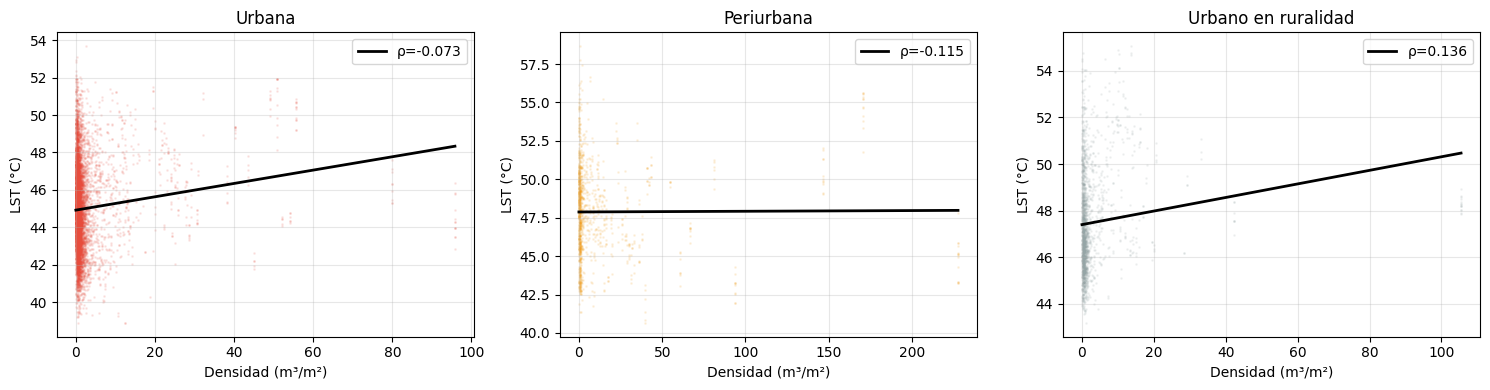

In [60]:
from rasterio import features
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

# Rasterize urban classifications to match LST grid
aglomerados_aligned = aglomerados_urbanos.to_crs(LST_max_computed.rio.crs)

clasificacion_to_code = {
    'urbana': 1,
    'periurbana': 2,
    'urbano en ruralidad': 3
}

aglomerados_aligned['code'] = aglomerados_aligned['clasificacion'].map(clasificacion_to_code)

clasificacion_raster = features.rasterize(
    shapes=((geom, value) for geom, value in zip(aglomerados_aligned.geometry, aglomerados_aligned['code'])),
    out_shape=LST_max_computed.shape,
    transform=LST_max_computed.rio.transform(),
    fill=0,
    dtype='uint8'
)

# Flatten rasters
volume_density_aligned = volume_density.rio.reproject_match(LST_max_computed)
density_flat = volume_density_aligned.values.flatten()
lst_flat = LST_max_computed.values.flatten()
clasificacion_flat = clasificacion_raster.flatten()

# Calculate statistics by urban type
results = []
for clasificacion, code in clasificacion_to_code.items():
    mask = (clasificacion_flat == code) & (~np.isnan(lst_flat)) & (~np.isnan(density_flat)) & (density_flat > 0)
    lst_class = lst_flat[mask]
    density_class = density_flat[mask]
    
    if len(lst_class) > 1:
        rho, p_value = stats.spearmanr(density_class, lst_class)
        slope, intercept, r_value, _, _ = stats.linregress(density_class, lst_class)
        
        results.append({
            'clasificacion': clasificacion,
            'n_pixels': len(lst_class),
            'spearman_rho': rho,
            'p_value': p_value,
            'slope': slope,
            'intercept': intercept,
            'r_squared': r_value**2,
            'mean_density': density_class.mean(),
            'mean_lst': lst_class.mean()
        })

df_results = pd.DataFrame(results)
print("\nRelación Densidad Volumétrica - LST por Tipo de Área:")
print(df_results.to_string(index=False))

# Visualization with scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = {'urbana': '#e74c3c', 'periurbana': '#f39c12', 'urbano en ruralidad': '#95a5a6'}

for idx, (clasificacion, code) in enumerate(clasificacion_to_code.items()):
    mask = (clasificacion_flat == code) & (~np.isnan(lst_flat)) & (~np.isnan(density_flat)) & (density_flat > 0)
    density = density_flat[mask]
    lst = lst_flat[mask]
    
    axes[idx].scatter(
        density,
        lst,
        s=1,
        alpha=0.1,
        color=colors[clasificacion],
        rasterized=True
    )
    
    row = df_results[df_results['clasificacion'] == clasificacion].iloc[0]
    x_line = np.array([density.min(), density.max()])
    y_line = row['slope'] * x_line + row['intercept']
    axes[idx].plot(x_line, y_line, 'k-', linewidth=2, 
                   label=f"ρ={row['spearman_rho']:.3f}")
    
    axes[idx].set_title(clasificacion.capitalize())
    axes[idx].set_xlabel("Densidad (m³/m²)")
    axes[idx].set_ylabel("LST (°C)")
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Explanatory model

In [61]:
from scipy import stats as sp_stats
from scipy.ndimage import gaussian_filter
from rasterio import features

# Rasterize urban classifications to match LST grid
aglomerados_aligned = aglomerados_urbanos.to_crs(LST_max_computed.rio.crs)

clasificacion_to_code = {
    'urbana': 1,
    'periurbana': 2,
    'urbano en ruralidad': 3
}

aglomerados_aligned['code'] = aglomerados_aligned['clasificacion'].map(clasificacion_to_code)

clasificacion_raster = features.rasterize(
    shapes=((geom, value) for geom, value in zip(aglomerados_aligned.geometry, aglomerados_aligned['code'])),
    out_shape=LST_max_computed.shape,
    transform=LST_max_computed.rio.transform(),
    fill=0,
    dtype='uint8'
)

# Prepare data using urban classification zones
canopy_flat = canopy_coverage_xr.values.flatten()
density_flat = volume_density_aligned.values.flatten()
distance_flat = distance_to_water.values.flatten()
lst_flat = LST_max_computed.values.flatten()
clasificacion_flat = clasificacion_raster.flatten()

# Filter for any pixel within urban classification zones
urban_mask = (
    (clasificacion_flat > 0)
    & (~np.isnan(lst_flat))
    & (~np.isnan(canopy_flat))
    & (~np.isnan(density_flat))
    & (~np.isnan(distance_flat))
)

df_urban = pd.DataFrame({
    "LST": lst_flat[urban_mask],
    "Canopy_Coverage": canopy_flat[urban_mask],
    "Building_Density": density_flat[urban_mask],
    "Distance_Water": distance_flat[urban_mask],
})

# Spatial lag model
sigma = 7.0

# Smooth predictors
canopy_smoothed = gaussian_filter(canopy_coverage_xr.values, sigma=sigma)
density_smoothed = gaussian_filter(np.log10(volume_density_aligned.values + 0.01), sigma=sigma)
distance_smoothed = gaussian_filter(distance_to_water.values, sigma=sigma)

df_urban["Canopy_Lag"] = canopy_smoothed.flatten()[urban_mask]
df_urban["Density_Lag"] = density_smoothed.flatten()[urban_mask]
df_urban["Distance_Lag"] = distance_smoothed.flatten()[urban_mask]

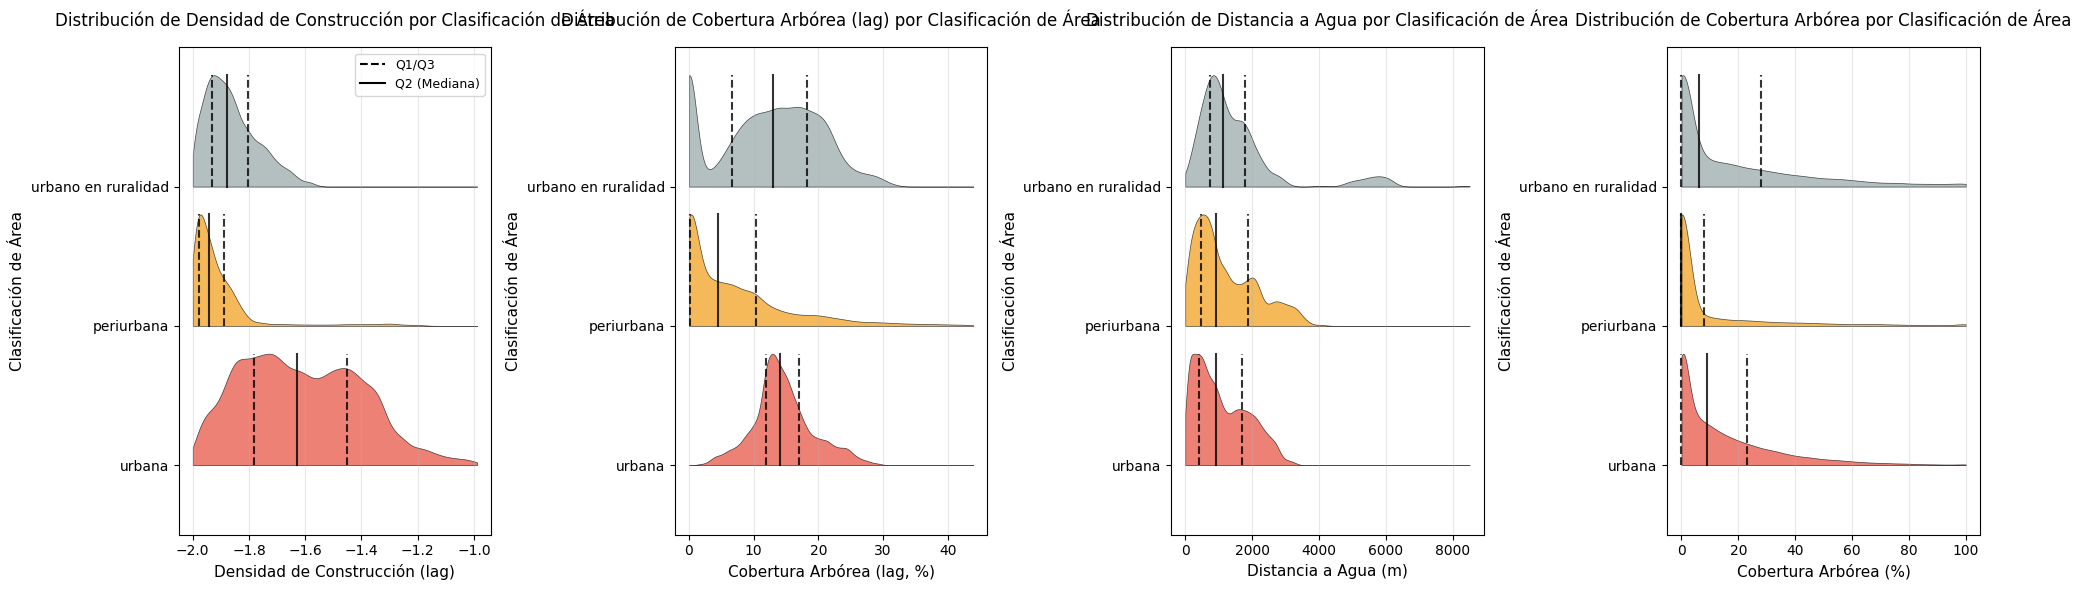

In [62]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Add clasificacion to df_urban
df_urban_classified = df_urban.copy()
df_urban_classified['code'] = clasificacion_flat[urban_mask]
code_to_clasificacion = {1: 'urbana', 2: 'periurbana', 3: 'urbano en ruralidad', 4: 'rural'}
df_urban_classified['clasificacion'] = df_urban_classified['code'].map(code_to_clasificacion)

clasificacion_colors = {
    'urbana': '#e74c3c',
    'periurbana': '#f39c12',
    'urbano en ruralidad': '#95a5a6'
}

# Fixed order for all subplots
clasificacion_order = ['urbana', 'periurbana', 'urbano en ruralidad']

# Features to plot
features_to_plot = [
    ('Density_Lag', 'Densidad de Construcción (lag)', 'Distribución de Densidad de Construcción por Clasificación de Área'),
    ('Canopy_Lag', 'Cobertura Arbórea (lag, %)', 'Distribución de Cobertura Arbórea (lag) por Clasificación de Área'),
    ('Distance_Water', 'Distancia a Agua (m)', 'Distribución de Distancia a Agua por Clasificación de Área'),
    ('Canopy_Coverage', 'Cobertura Arbórea (%)', 'Distribución de Cobertura Arbórea por Clasificación de Área')
]

# Create figure with 4 subplots in a row
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

for idx, (feature_col, xlabel, title) in enumerate(features_to_plot):
    ax = axes[idx]
    
    for i, clasificacion in enumerate(clasificacion_order):
        data = df_urban_classified[df_urban_classified['clasificacion'] == clasificacion][feature_col].dropna()
        
        if len(data) > 1:
            # Calculate kernel density estimation
            density = stats.gaussian_kde(data)
            xs = np.linspace(df_urban_classified[feature_col].min(), df_urban_classified[feature_col].max(), 500)
            density_values = density(xs)
            
            # Normalize and offset density for this row
            density_values = density_values / density_values.max() * 0.8
            
            # Plot density curve
            ax.fill_between(
                xs,
                i,
                i + density_values,
                alpha=0.7,
                color=clasificacion_colors.get(clasificacion, '#95a5a6'),
                edgecolor='black',
                linewidth=0.5
            )
            
            # Calculate and plot quartiles
            q1 = data.quantile(0.25)
            q2 = data.quantile(0.50)
            q3 = data.quantile(0.75)
            
            # Plot quartile lines
            for q, style in [(q1, '--'), (q2, '-'), (q3, '--')]:
                ax.plot([q, q], [i, i + 0.8], 
                       color='black', 
                       linestyle=style, 
                       linewidth=1.5, 
                       alpha=0.8)
    
    ax.set_yticks(range(len(clasificacion_order)))
    ax.set_yticklabels(clasificacion_order)
    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_ylabel("Clasificación de Área", fontsize=11)
    ax.set_title(title, fontsize=12, pad=15)
    ax.grid(axis="x", alpha=0.3)
    ax.set_ylim(-0.5, len(clasificacion_order))
    
    # Add legend only to the first subplot
    if idx == 0:
        legend_elements = [
            Line2D([0], [0], color='black', linestyle='--', linewidth=1.5, label='Q1/Q3'),
            Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, label='Q2 (Mediana)')
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
# plt.savefig('distribuciones_clasificacion.svg', format='svg', bbox_inches='tight')
plt.show()

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import shap
import pandas as pd
import numpy as np

# ============================================================================
# STEP 1: Prepare land cover data
# ============================================================================

# Align land cover to LST grid
suelo_aligned = suelo_2022.rio.reproject_match(LST_max_computed)

# Create one-hot encoded land cover features
land_cover_flat = suelo_aligned.values.flatten()

# Define major land cover classes (group some of the 16 categories)
# You can adjust these groupings based on what makes sense
lc_classes = {
    'lc_woody_closed': [3],  # Leñosa cerrada
    'lc_woody_open': [4, 45],  # Leñosa abierta + dispersa
    'lc_grassland': [12, 63],  # Pastizal + Estepa
    'lc_pasture': [15],  # Pastura
    'lc_agriculture': [18, 36],  # Agricultura + Cultivo arbustivo
    'lc_forest_plantation': [9],  # Plantación forestal
    'lc_wetland': [6, 11],  # Leñosa inundable + Vegetación no leñosa inundable
    'lc_bare': [22],  # Área sin vegetación
    'lc_water': [33],  # Río, lago u océano
}

# Create binary columns for each land cover class
lc_features = {}
for lc_name, lc_ids in lc_classes.items():
    lc_mask = np.isin(land_cover_flat, lc_ids)
    lc_features[lc_name] = lc_mask.astype(int)

In [64]:
# ============================================================================
# STEP 2: Prepare all features for modeling
# ============================================================================

# Get settlement type (clasificacion)
clasificacion_flat = clasificacion_raster.flatten()

# Create urban classification one-hot encoded
clasificacion_features = {
    'area_urbana': (clasificacion_flat == 1).astype(int),
    'area_periurbana': (clasificacion_flat == 2).astype(int),
    'area_rural': (clasificacion_flat == 3).astype(int),
}

# Combine everything into a dataframe
df_model = pd.DataFrame({
    "LST": lst_flat[urban_mask],
    "Canopy_Coverage": canopy_flat[urban_mask],
    "Building_Density_Log": np.log10(density_flat[urban_mask] + 0.01),
    "Distance_Water": distance_flat[urban_mask],
    "Canopy_Lag": canopy_smoothed.flatten()[urban_mask],
    "Building_Density_Lag": density_smoothed.flatten()[urban_mask],
    # Drop one distance variable to avoid multicollinearity issues
    # Keep neighborhood distance since it had stronger effect
    # "Distance_Lag": distance_smoothed.flatten()[urban_mask],
})

# Add land cover one-hot features
for lc_name, lc_array in lc_features.items():
    df_model[lc_name] = lc_array[urban_mask]

# Add settlement type one-hot features (drop one as reference - urbana)
df_model['area_periurbana'] = clasificacion_features['area_periurbana'][urban_mask]
df_model['area_rural'] = clasificacion_features['area_rural'][urban_mask]

# Also add coordinates for spatial blocking
coords = np.argwhere(~np.isnan(LST_max_computed.values))
x_coords = coords[:, 1][urban_mask]
y_coords = coords[:, 0][urban_mask]
df_model['x_coord'] = x_coords
df_model['y_coord'] = y_coords

print(f"Total features: {df_model.shape[1] - 3}")  # -3 for LST, x_coord, y_coord
print(f"Samples: {len(df_model):,}\n")

Total features: 16
Samples: 76,681



In [65]:
# ============================================================================
# STEP 3: Prepare for modeling with spatial cross-validation
# ============================================================================

# Create spatial blocks for cross-validation (e.g., ~5km grid cells)
# Adjust block_size based on your pixel resolution
pixel_resolution = 30  # meters (adjust to your actual resolution)
block_size_pixels = int(500 / pixel_resolution)  # ~500m blocks

df_model['spatial_block'] = (
    (df_model['x_coord'] // block_size_pixels).astype(str) + '_' + 
    (df_model['y_coord'] // block_size_pixels).astype(str)
)

# Prepare X and y
feature_cols = [col for col in df_model.columns 
                if col not in ['LST', 'x_coord', 'y_coord', 'spatial_block']]
X = df_model[feature_cols].values
y = df_model['LST'].values
spatial_blocks = df_model['spatial_block'].values

print("Features included:")
for i, col in enumerate(feature_cols):
    print(f"  {i+1}. {col}")
print()

Features included:
  1. Canopy_Coverage
  2. Building_Density_Log
  3. Distance_Water
  4. Canopy_Lag
  5. Building_Density_Lag
  6. lc_woody_closed
  7. lc_woody_open
  8. lc_grassland
  9. lc_pasture
  10. lc_agriculture
  11. lc_forest_plantation
  12. lc_wetland
  13. lc_bare
  14. lc_water
  15. area_periurbana
  16. area_rural



In [66]:
area_urbana = aglomerados_urbanos[aglomerados_urbanos['clasificacion'] == 'urbana'].to_crs(canopy_coverage_xr.rio.crs)

In [48]:
# Reproject volume_density to match the other rasters
volume_density_reprojected = volume_density.rio.reproject("EPSG:3857")

print("Volume reprojected bounds:", volume_density_reprojected.rio.bounds())
print("Volume reprojected CRS:", volume_density_reprojected.rio.crs)

# Now clip all three
canopy_clipped = canopy_coverage_xr.rio.clip(
    area_urbana_aligned.geometry, 
    drop=True
)
volume_clipped = volume_density_reprojected.rio.clip(
    area_urbana_aligned.geometry, 
    drop=True
)
distance_clipped = distance_to_water.rio.clip(
    area_urbana_aligned.geometry, 
    drop=True
)

# Write to files
canopy_clipped.rio.to_raster("canopy_coverage_percent_urban.tif")
volume_clipped.rio.to_raster("volume_density_urban.tif")
distance_clipped.rio.to_raster("distance_to_water_urban.tif")

print(f"Canopy: {canopy_clipped.shape}")
print(f"Volume: {volume_clipped.shape}")
print(f"Distance: {distance_clipped.shape}")

Volume reprojected bounds: (-6784921.949747397, -4053043.2035388215, -6694499.52435718, -3966730.8883936135)
Volume reprojected CRS: EPSG:3857


NameError: name 'area_urbana_aligned' is not defined

In [67]:
# ============================================================================
# STEP 4: Spatial Cross-Validation
# ============================================================================

print("Running spatial cross-validation...\n")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=50,
    min_samples_leaf=20,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

# Spatial GroupKFold
gkf = GroupKFold(n_splits=15)

cv_r2_scores = []
cv_rmse_scores = []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=spatial_blocks), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    cv_r2_scores.append(r2)
    cv_rmse_scores.append(rmse)
    
    print(f"Fold {fold}: R² = {r2:.4f}, RMSE = {rmse:.2f}°C")

print(f"\nCross-validation Results:")
print(f"  Mean R² = {np.mean(cv_r2_scores):.4f} (±{np.std(cv_r2_scores):.4f})")
print(f"  Mean RMSE = {np.mean(cv_rmse_scores):.2f}°C (±{np.std(cv_rmse_scores):.2f}°C)")

Running spatial cross-validation...

Fold 1: R² = 0.6160, RMSE = 1.77°C
Fold 2: R² = 0.6704, RMSE = 1.70°C
Fold 3: R² = 0.6841, RMSE = 1.71°C
Fold 4: R² = 0.6989, RMSE = 1.48°C
Fold 5: R² = 0.5857, RMSE = 1.78°C
Fold 6: R² = 0.6620, RMSE = 1.64°C
Fold 7: R² = 0.7128, RMSE = 1.44°C
Fold 8: R² = 0.6443, RMSE = 1.48°C
Fold 9: R² = 0.6888, RMSE = 1.74°C
Fold 10: R² = 0.6778, RMSE = 1.63°C
Fold 11: R² = 0.7177, RMSE = 1.78°C
Fold 12: R² = 0.7934, RMSE = 1.55°C
Fold 13: R² = 0.7678, RMSE = 1.45°C
Fold 14: R² = 0.7322, RMSE = 1.62°C
Fold 15: R² = 0.7285, RMSE = 1.74°C

Cross-validation Results:
  Mean R² = 0.6920 (±0.0523)
  Mean RMSE = 1.63°C (±0.12°C)


In [68]:
# ============================================================================
# STEP 5: Train final model on all data
# ============================================================================

print("\nTraining final model on all data...\n")
rf_final = RandomForestRegressor(
    n_estimators=200,  # More trees for final model
    max_depth=20,
    min_samples_split=50,
    min_samples_leaf=20,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

rf_final.fit(X, y)
y_pred_final = rf_final.predict(X)

r2_final = r2_score(y, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y, y_pred_final))

print(f"Final Model Performance:")
print(f"  R² = {r2_final:.4f}")
print(f"  RMSE = {rmse_final:.2f}°C\n")


Training final model on all data...

Final Model Performance:
  R² = 0.8064
  RMSE = 1.31°C



In [69]:
# ============================================================================
# STEP 6: Feature Importance
# ============================================================================

print("=" * 80)
print("FEATURE IMPORTANCE")
print("=" * 80)

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_final.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_importance.iterrows():
    print(f"{row['feature']:<30s} {row['importance']:>8.4f}")

FEATURE IMPORTANCE
Canopy_Lag                       0.3019
Building_Density_Lag             0.2840
Distance_Water                   0.1204
Canopy_Coverage                  0.1033
lc_bare                          0.0608
area_periurbana                  0.0426
lc_grassland                     0.0278
area_rural                       0.0174
Building_Density_Log             0.0138
lc_forest_plantation             0.0109
lc_pasture                       0.0100
lc_agriculture                   0.0027
lc_water                         0.0026
lc_woody_closed                  0.0016
lc_woody_open                    0.0002
lc_wetland                       0.0001


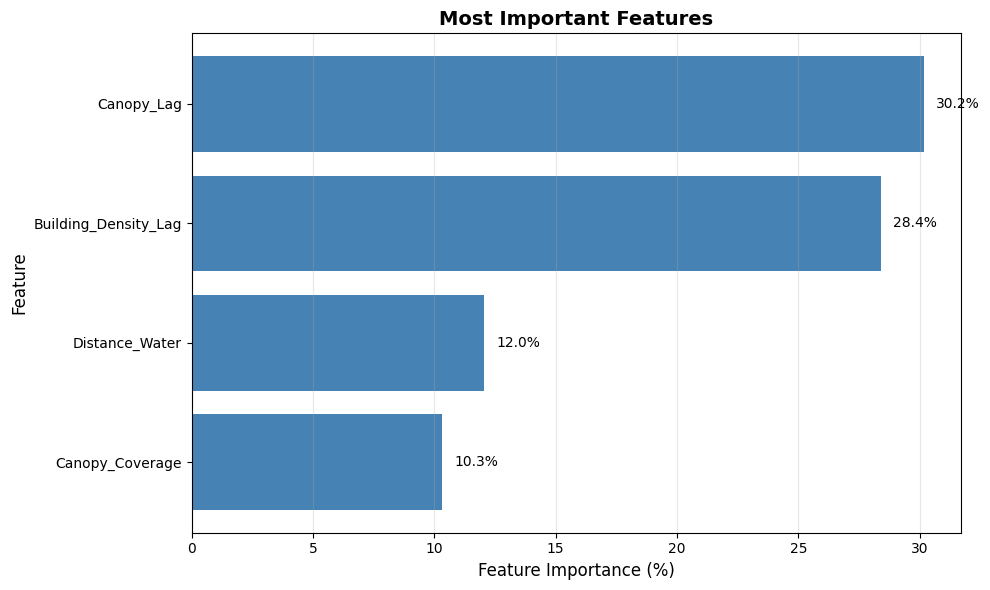

In [71]:
import matplotlib.pyplot as plt

# Get top 10 features (already sorted descending)
top_10 = feature_importance.head(4).iloc[::-1]  # Reverse for plotting

# Create horizontal bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(top_10['feature'], top_10['importance'] * 100, color='steelblue')

# Add percentage labels to bars
for i, (idx, row) in enumerate(top_10.iterrows()):
    ax.text(row['importance'] * 100 + 0.5, i, f"{row['importance']*100:.1f}%", 
            va='center', fontsize=10)

ax.set_xlabel('Feature Importance (%)', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Most Important Features', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance_pergamino.svg', format='svg', bbox_inches='tight')
plt.show()



Computing SHAP values (this may take a few minutes)...

SHAP computed for 10,000 samples
  Urbana: 5,459
  Periurbana: 2,259
  Rural: 2,282

OVERALL SHAP STATISTICS
Feature                        |  Mean SHAP |     |Mean| |      Std | Effect      
----------------------------------------------------------------------------------------------------
Canopy_Lag                     |    +0.0085 |     0.8628 |   1.0275 | Mixed/Neutral
Building_Density_Lag           |    +0.0133 |     0.7581 |   0.9331 | Mixed/Neutral
Distance_Water                 |    +0.0204 |     0.4724 |   0.5662 | Mixed/Neutral
Canopy_Coverage                |    -0.0039 |     0.4251 |   0.4563 | Mixed/Neutral
lc_bare                        |    -0.0099 |     0.2883 |   0.3216 | Mixed/Neutral
lc_grassland                   |    -0.0161 |     0.1570 |   0.1725 | Mixed/Neutral
area_periurbana                |    -0.0268 |     0.1508 |   0.2001 | Mixed/Neutral
area_rural                     |    +0.0125 |     0.0822 |   

2025-11-14 11:25:55,357 - distributed.nanny - WARNING - Restarting worker
2025-11-14 11:25:55,409 - distributed.nanny - WARNING - Restarting worker
2025-11-14 11:25:55,486 - distributed.nanny - WARNING - Restarting worker
2025-11-14 11:25:55,541 - distributed.nanny - WARNING - Restarting worker
2025-11-14 11:25:55,589 - distributed.nanny - WARNING - Restarting worker
2025-11-14 11:25:55,696 - distributed.nanny - WARNING - Restarting worker
2025-11-14 11:25:55,740 - distributed.nanny - WARNING - Restarting worker
2025-11-14 11:25:55,791 - distributed.nanny - WARNING - Restarting worker
2025-11-14 11:25:55,934 - distributed.nanny - WARNING - Restarting worker
2025-11-14 11:25:55,937 - distributed.nanny - WARNING - Restarting worker
2025-11-14 11:25:55,939 - distributed.nanny - WARNING - Restarting worker
2025-11-14 11:25:55,943 - distributed.nanny - WARNING - Restarting worker
2025-11-14 11:25:55,950 - distributed.nanny - WARNING - Restarting worker
2025-11-14 11:25:55,956 - distributed.

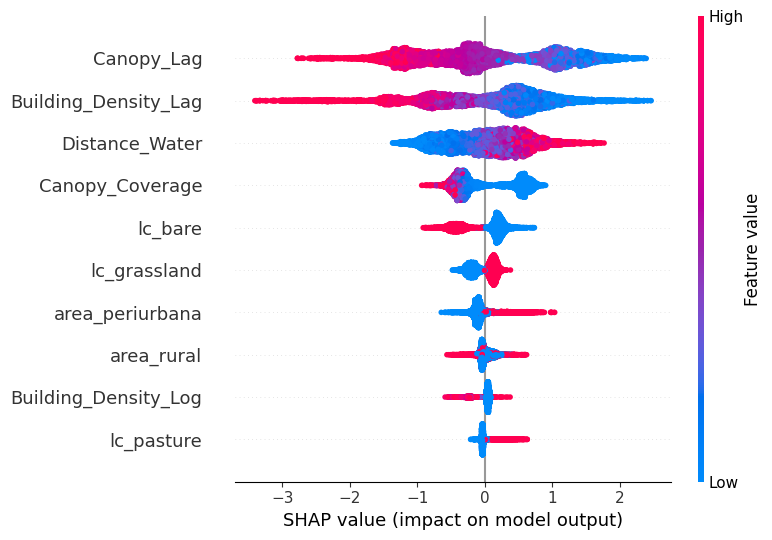


SHAP ANALYSIS BY SETTLEMENT TYPE

URBANA (n=5,459)
----------------------------------------------------------------------------------------------------
Feature                        |  Mean SHAP |     |Mean| |      Std | Effect      
----------------------------------------------------------------------------------------------------
Building_Density_Lag           |    -0.4454 |     0.8477 |   0.9483 | COOLING ↓   
Canopy_Lag                     |    -0.2679 |     0.6752 |   0.7933 | COOLING ↓   
Distance_Water                 |    -0.0026 |     0.4586 |   0.5385 | Mixed       
Canopy_Coverage                |    -0.0821 |     0.4017 |   0.4275 | COOLING ↓   
lc_bare                        |    -0.1244 |     0.3747 |   0.3762 | COOLING ↓   
lc_grassland                   |    -0.0713 |     0.1772 |   0.1799 | COOLING ↓   
area_periurbana                |    -0.1048 |     0.1130 |   0.0651 | COOLING ↓   
Building_Density_Log           |    -0.0139 |     0.0897 |   0.1259 | Mixed       

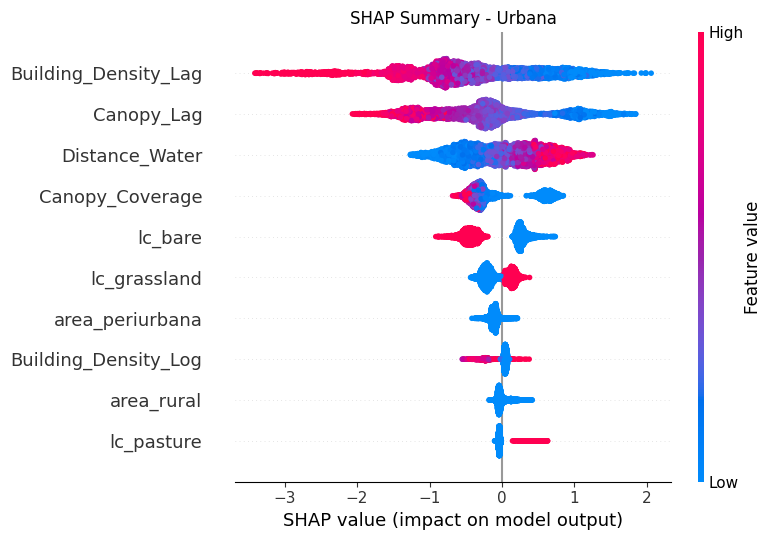


PERIURBANA (n=2,259)
----------------------------------------------------------------------------------------------------
Feature                        |  Mean SHAP |     |Mean| |      Std | Effect      
----------------------------------------------------------------------------------------------------
Canopy_Lag                     |    +0.6504 |     1.2235 |   1.1815 | HEATING ↑   
Building_Density_Lag           |    +0.6616 |     0.7688 |   0.6299 | HEATING ↑   
Distance_Water                 |    -0.0354 |     0.6413 |   0.7421 | Mixed       
Canopy_Coverage                |    +0.1895 |     0.4846 |   0.4705 | HEATING ↑   
area_periurbana                |    +0.2514 |     0.2734 |   0.2404 | HEATING ↑   
lc_bare                        |    +0.1196 |     0.1809 |   0.1595 | HEATING ↑   
lc_grassland                   |    +0.0561 |     0.1485 |   0.1483 | HEATING ↑   
area_rural                     |    +0.0579 |     0.0731 |   0.0683 | HEATING ↑   
Building_Density_Log         

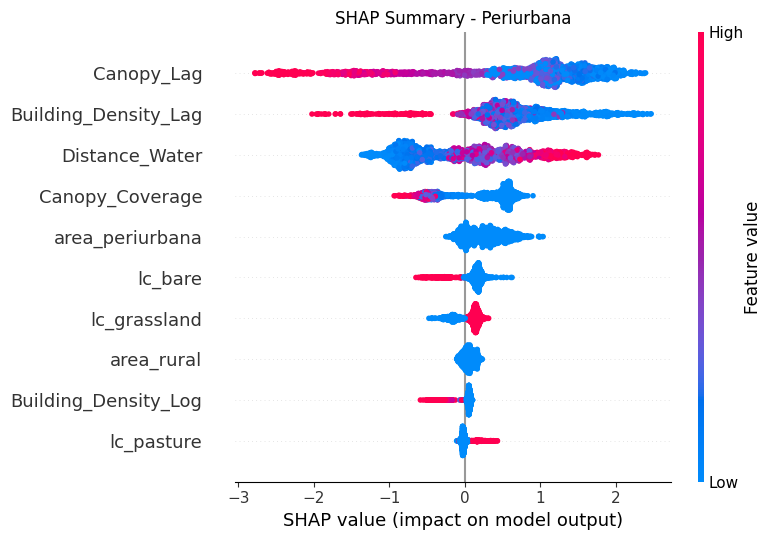


RURAL (n=2,282)
----------------------------------------------------------------------------------------------------
Feature                        |  Mean SHAP |     |Mean| |      Std | Effect      
----------------------------------------------------------------------------------------------------
Canopy_Lag                     |    +0.0344 |     0.9546 |   1.0713 | Mixed       
Building_Density_Lag           |    +0.4687 |     0.5330 |   0.3806 | HEATING ↑   
Canopy_Coverage                |    -0.0084 |     0.4221 |   0.4520 | Mixed       
Distance_Water                 |    +0.1307 |     0.3382 |   0.3865 | HEATING ↑   
lc_bare                        |    +0.1358 |     0.1879 |   0.1424 | HEATING ↑   
area_rural                     |    -0.0044 |     0.1483 |   0.1924 | Mixed       
area_periurbana                |    -0.1156 |     0.1197 |   0.0946 | COOLING ↓   
lc_grassland                   |    +0.0443 |     0.1174 |   0.1227 | Mixed       
lc_pasture                     |  

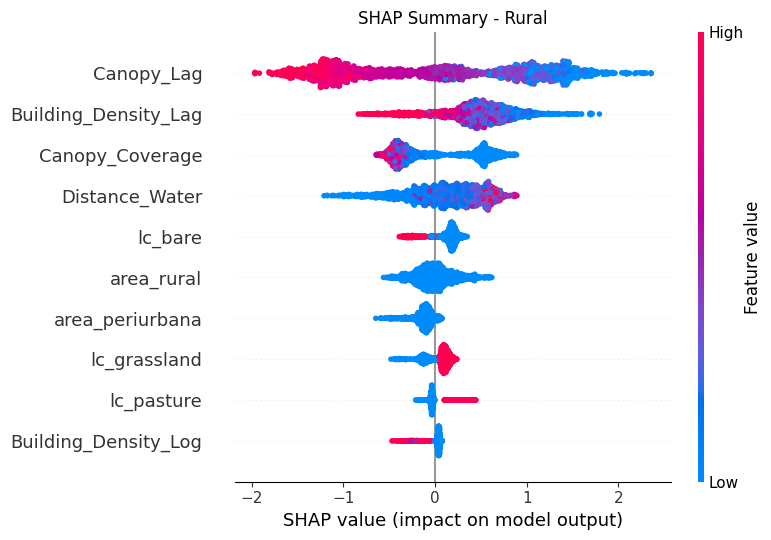


KEY VARIABLES COMPARISON ACROSS SETTLEMENT TYPES
Feature                        |          Urbana |      Periurbana |           Rural
----------------------------------------------------------------------------------------------------
Canopy_Lag                     |         -0.2679 |         +0.6504 |         +0.0344
Building_Density_Lag           |         -0.4454 |         +0.6616 |         +0.4687
Distance_Water                 |         -0.0026 |         -0.0354 |         +0.1307
Canopy_Coverage                |         -0.0821 |         +0.1895 |         -0.0084
lc_bare                        |         -0.1244 |         +0.1196 |         +0.1358
lc_grassland                   |         -0.0713 |         +0.0561 |         +0.0443
area_periurbana                |         -0.1048 |         +0.2514 |         -0.1156
area_rural                     |         +0.0008 |         +0.0579 |         -0.0044

✓ Positive = Heating effect | ✗ Negative = Cooling effect

Analysis complete!


In [ ]:
# ============================================================================
# STEP 7: SHAP Values for Interpretation (SINGLE COMPUTATION)
# ============================================================================
print("\n\nComputing SHAP values (this may take a few minutes)...\n")

# Sample strategically - proportional to settlement types
sample_size = min(10000, len(X))  # Larger sample for better settlement coverage
sample_idx = np.random.choice(len(X), sample_size, replace=False)
X_sample = X[sample_idx]

# Get settlement types for the sample
sample_settlements = clasificacion_flat[urban_mask][sample_idx]

# Compute SHAP once
explainer = shap.TreeExplainer(rf_final)
shap_values = explainer.shap_values(X_sample)

print(f"SHAP computed for {sample_size:,} samples")
print(f"  Urbana: {(sample_settlements == 1).sum():,}")
print(f"  Periurbana: {(sample_settlements == 2).sum():,}")
print(f"  Rural: {(sample_settlements == 3).sum():,}\n")

# ============================================================================
# Overall SHAP Statistics
# ============================================================================
print("=" * 100)
print("OVERALL SHAP STATISTICS")
print("=" * 100)
print(f"{'Feature':<30s} | {'Mean SHAP':>10s} | {'|Mean|':>10s} | {'Std':>8s} | {'Effect':<12s}")
print("-" * 100)

shap_stats = []
for i, feature in enumerate(feature_cols):
    mean_shap = shap_values[:, i].mean()
    abs_mean = np.abs(shap_values[:, i]).mean()
    std_shap = shap_values[:, i].std()
    
    # Determine primary effect
    if abs(mean_shap) < 0.05:
        effect = "Mixed/Neutral"
    elif mean_shap > 0:
        effect = "HEATING ↑"
    else:
        effect = "COOLING ↓"
    
    shap_stats.append({
        'Feature': feature,
        'Mean_SHAP': mean_shap,
        'Abs_Mean': abs_mean,
        'Std': std_shap,
        'Effect': effect
    })

shap_df = pd.DataFrame(shap_stats).sort_values('Abs_Mean', ascending=False)

for _, row in shap_df.iterrows():
    print(f"{row['Feature']:<30s} | {row['Mean_SHAP']:>+10.4f} | {row['Abs_Mean']:>10.4f} | "
          f"{row['Std']:>8.4f} | {row['Effect']:<12s}")
print("=" * 100)
print()

# Overall SHAP plot
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, show=False, max_display=10)
plt.tight_layout()
plt.savefig('shap_summary_all.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# Settlement-Specific SHAP Analysis (using already-computed values)
# ============================================================================
print("\n" + "=" * 100)
print("SHAP ANALYSIS BY SETTLEMENT TYPE")
print("=" * 100)

settlement_names = {1: 'Urbana', 2: 'Periurbana', 3: 'Rural'}

# Store for comparison
settlement_comparison = {}

for area_code, area_name in [(1, 'Urbana'), (2, 'Periurbana'), (3, 'Rural')]:
    # Subset already-computed SHAP values
    area_mask = (sample_settlements == area_code)
    shap_area = shap_values[area_mask]
    X_area = X_sample[area_mask]
    
    n_samples = area_mask.sum()
    
    print(f"\n{area_name.upper()} (n={n_samples:,})")
    print("-" * 100)
    print(f"{'Feature':<30s} | {'Mean SHAP':>10s} | {'|Mean|':>10s} | {'Std':>8s} | {'Effect':<12s}")
    print("-" * 100)
    
    area_stats = []
    for i, feature in enumerate(feature_cols):
        mean_shap = shap_area[:, i].mean()
        abs_mean = np.abs(shap_area[:, i]).mean()
        std_shap = shap_area[:, i].std()
        
        # Determine primary effect
        if abs(mean_shap) < 0.05:
            effect = "Mixed"
        elif mean_shap > 0:
            effect = "HEATING ↑"
        else:
            effect = "COOLING ↓"
        
        area_stats.append({
            'Feature': feature,
            'Mean_SHAP': mean_shap,
            'Abs_Mean': abs_mean,
            'Std': std_shap,
            'Effect': effect
        })
    
    area_df = pd.DataFrame(area_stats).sort_values('Abs_Mean', ascending=False)
    settlement_comparison[area_name] = area_df
    
    # Print top 10
    for _, row in area_df.head(10).iterrows():
        print(f"{row['Feature']:<30s} | {row['Mean_SHAP']:>+10.4f} | {row['Abs_Mean']:>10.4f} | "
              f"{row['Std']:>8.4f} | {row['Effect']:<12s}")
    
    print("-" * 100)
    
    # Generate plot
    shap.summary_plot(shap_area, X_area, feature_names=feature_cols, 
                     show=False, max_display=10)
    plt.title(f'SHAP Summary - {area_name}')
    plt.tight_layout()
    plt.savefig(f'shap_summary_{area_name.lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# Cross-Settlement Comparison (Top 8 Features Only)
# ============================================================================
print("\n" + "=" * 100)
print("KEY VARIABLES COMPARISON ACROSS SETTLEMENT TYPES")
print("=" * 100)
print(f"{'Feature':<30s} | {'Urbana':>15s} | {'Periurbana':>15s} | {'Rural':>15s}")
print("-" * 100)

# Get top features from overall analysis
top_features = shap_df.head(8)['Feature'].tolist()

for feature in top_features:
    urbana_val = settlement_comparison['Urbana'][
        settlement_comparison['Urbana']['Feature'] == feature]['Mean_SHAP'].values[0]
    periurbana_val = settlement_comparison['Periurbana'][
        settlement_comparison['Periurbana']['Feature'] == feature]['Mean_SHAP'].values[0]
    rural_val = settlement_comparison['Rural'][
        settlement_comparison['Rural']['Feature'] == feature]['Mean_SHAP'].values[0]
    
    print(f"{feature:<30s} | {urbana_val:>+15.4f} | {periurbana_val:>+15.4f} | {rural_val:>+15.4f}")

print("=" * 100)
print("\n✓ Positive = Heating effect | ✗ Negative = Cooling effect")
print("\nAnalysis complete!")

## Risk analysis

### Exposición

#### GHSL (2025, 100m)

In [7]:
aoi = aglomerados_urbanos

# URL del archivo GHSL que contiene los datos de población
ghsl_url = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2025_GLOBE_R2023A_54009_100/V1-0/tiles/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13.zip"

# Crear ruta virtual para acceder al archivo ZIP remoto sin descargarlo completamente
# vsizip permite leer archivos dentro de un ZIP, vsicurl permite leer desde una URL
vsi_path = (
    f"/vsizip/vsicurl/{ghsl_url}/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13.tif"
)

In [8]:
# TODO: cargar el raster GHSL usando rio.open_rasterio
#       usar chunks={"x": 2048, "y": 2048} para lectura eficiente
#       llamar el resultado ghsl
ghsl = rio.open_rasterio(
    vsi_path,
    chunks={"x": 2048, "y": 2048},
)

# TODO: reproyectar aoi al CRS de GHSL ("ESRI:54009" = Mollweide)
#       llamar el resultado aoi_54009
aoi_54009 = aoi.to_crs("ESRI:54009")

# TODO: recortar GHSL al área de interés usando .rio.clip con from_disk=True
#       llamar el resultado ghsl_clipped
ghsl_clipped = ghsl.rio.clip(
    aoi_54009.geometry.values,
    from_disk=True,
)

# TODO: reproyectar ghsl_clipped a USE_CRS
ghsl_clipped = ghsl_clipped.rio.reproject(USE_CRS)

# TODO: enmascarar valores <= 0 usando .where(ghsl_clipped > 0)
#       llamar el resultado ghsl_masked
ghsl_masked = ghsl_clipped.where(ghsl_clipped > 0)

# TODO: imprimir la población total
print(f"Población total GHSL: {float(ghsl_masked.sum().values):,.0f}")

Población total GHSL: 163,492


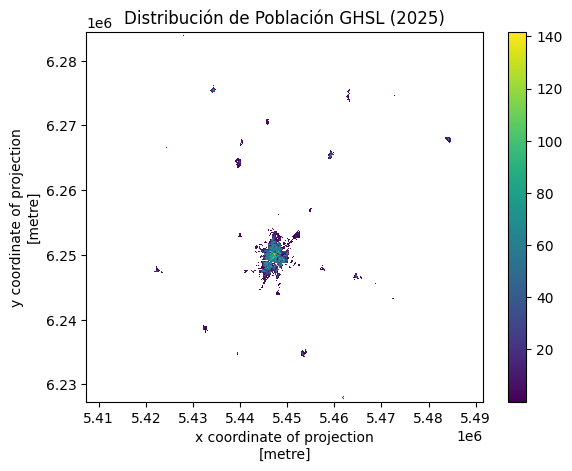

In [9]:
ghsl_masked.plot()
plt.title("Distribución de Población GHSL (2025)")
plt.show()

#### Censo argentino (2022, radio censal)

In [10]:
# Configurar DuckDB con extensiones espaciales y acceso a S3
con = duckdb.connect()
for cmd in [
    "INSTALL spatial",  # Para trabajar con geometrías
    "LOAD spatial",
    "INSTALL httpfs",  # Para leer archivos desde S3
    "LOAD httpfs",
    "SET s3_region='us-east-2'",  # Región donde están alojados los datos
]:
    con.execute(cmd)

temp_file = "privacion_data.parquet"

# borrar el archivo si existe
if os.path.exists(temp_file):
    os.remove(temp_file)

WGS84_CRS = "EPSG:4326"

# obtener los límites de aoi en CRS_WGS84
bounds = aoi.to_crs(WGS84_CRS).total_bounds

# Consulta SQL que:
# 1. Calcula porcentaje de privación por radio censal
#    - HOGAR_IPMH categorías 2, 3, 4 indican hogares con privación
#    - Suma hogares con privación y total de hogares por id_geo
# 2. Une con geometrías de radios censales desde radios-2022.parquet
# 3. Filtra espacialmente usando los límites (bounds) de nuestra área de interés
# 4. Exporta a archivo Parquet local para análisis posterior
query = f"""
COPY (
    WITH privacion_data AS (
        SELECT 
            id_geo,
            SUM(CASE WHEN valor_categoria IN ('2', '3', '4') THEN conteo ELSE 0 END) AS hogares_con_privacion,
            SUM(conteo) AS total_hogares,
            ROUND((hogares_con_privacion * 100.0) / total_hogares, 2) AS porcentaje_privacion
        FROM 's3://arg-fulbright-data/censo-argentino-2022/censo-2022-largo.parquet'
        WHERE codigo_variable = 'HOGAR_IPMH'
        GROUP BY id_geo
        HAVING total_hogares > 0
    )
    SELECT 
        g.cod_2022,
        g.prov,
        g.depto, 
        g.pob_tot_p,
        g.geometry,
        p.hogares_con_privacion,
        p.total_hogares,
        p.porcentaje_privacion
    FROM 's3://arg-fulbright-data/censo-argentino-2022/radios-2022.parquet' g
    JOIN privacion_data p ON g.cod_2022 = p.id_geo
    WHERE ST_XMax(g.geometry) >= {bounds[0]} 
      AND ST_XMin(g.geometry) <= {bounds[2]}
      AND ST_YMax(g.geometry) >= {bounds[1]} 
      AND ST_YMin(g.geometry) <= {bounds[3]}
) TO '{temp_file}' (FORMAT PARQUET);
"""

# ejecutar la consulta
con.execute(query)

# leer el archivo parquet usando pd.read_parquet
df = pd.read_parquet(temp_file)
# convertir la columna geometry desde WKB usando gpd.GeoSeries.from_wkb
df["geometry"] = gpd.GeoSeries.from_wkb(df["geometry"])
# crear un GeoDataFrame con crs="4326"
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="4326")

# reproyectar a USE_CRS y recortar al aoi usando .to_crs().clip()
gdf = gdf.to_crs(USE_CRS).clip(aoi)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

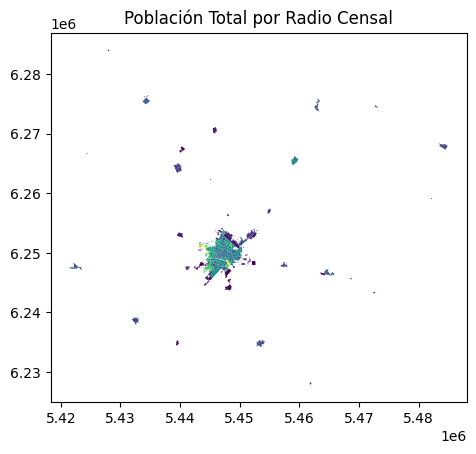

In [11]:
gdf.plot("POB_TOT_P")
plt.title("Población Total por Radio Censal")
plt.show()

#### Bajada de escala de datos censales

In [12]:
raster_referencia = ghsl_clipped
transformacion_referencia = raster_referencia.rio.transform()
crs_referencia = raster_referencia.rio.crs
forma_referencia = raster_referencia.shape[1:]
raster_ghsl = ghsl_clipped.values[0]

geometrias = [geom for geom in gdf.geometry]

# Opción 1: Usar el mismo método para ambos
# Reemplazar zonal_stats con cálculo basado en rasterize
raster_ghsl_full = rasterize(
    [(geom, i + 1) for i, geom in enumerate(gdf.geometry)],
    out_shape=forma_referencia,
    transform=transformacion_referencia,
    fill=0,
    all_touched=True,
    dtype=np.int32,
)

# Calcular totales desde la versión rasterizada
totales_ghsl = []
for i in range(len(gdf.geometry)):
    polygon_mask = raster_ghsl_full == (i + 1)  # +1 porque rasterize comienza en 1

    # Aplicar máscara de polígono Y excluir valores nodata
    valid_mask = polygon_mask & (raster_ghsl > 0) & (raster_ghsl != -200)

    total = np.sum(raster_ghsl[valid_mask]) if np.any(valid_mask) else 0
    totales_ghsl.append(total)

gdf["estimacion_pob_ghsl"] = totales_ghsl

geometrias_ghsl = [
    (geom, valor)
    for geom, valor in zip(
        gdf.geometry,
        gdf["estimacion_pob_ghsl"],
    )
]
geometrias_pob = [(geom, valor) for geom, valor in zip(gdf.geometry, gdf["POB_TOT_P"])]

raster_pob_ghsl = rasterize(
    geometrias_ghsl,
    out_shape=forma_referencia,
    transform=transformacion_referencia,
    fill=0,
    dtype=np.float32,
    all_touched=True,
)

raster_pob_censo = rasterize(
    geometrias_pob,
    out_shape=forma_referencia,
    transform=transformacion_referencia,
    fill=0,
    dtype=np.float32,
    all_touched=True,
)

mascara = (raster_ghsl > 0) & (raster_ghsl != -200) & (raster_pob_ghsl > 0.1)
ghsl_fraccional = np.full_like(raster_ghsl, 0, dtype=np.float64)
ghsl_fraccional[mascara] = raster_ghsl[mascara] / raster_pob_ghsl[mascara]

mascara2 = (ghsl_fraccional > 0) & (raster_pob_censo > 0)
pob_redistribuida = np.full_like(raster_ghsl, 0, dtype=np.float64)
pob_redistribuida[mascara2] = ghsl_fraccional[mascara2] * raster_pob_censo[mascara2]

pob_redistribuida_da = xr.DataArray(
    pob_redistribuida,
    coords={"y": ghsl_clipped.y, "x": ghsl_clipped.x},
    dims=["y", "x"],
    attrs=ghsl_clipped.attrs.copy(),
)

pob_redistribuida_da = pob_redistribuida_da.rio.write_crs(USE_CRS)

pob_redistribuida_enmascarada = pob_redistribuida_da.where(pob_redistribuida_da > 0)

total_redistribuido = pob_redistribuida[pob_redistribuida > 0].sum()
total_censo = gdf["POB_TOT_P"].sum()

# TODO: imprimir la población total segun el censo, la población total redistribuida
# y el porcentaje de conservación (total redistribuido / total censo)
print(f"Población censo: {total_censo:,.0f}")
print(f"Población redistribuida: {total_redistribuido:,.0f}")
print(f"Conservación: {(total_redistribuido / total_censo) * 100:.2f}%")

Población censo: 114,472
Población redistribuida: 114,139
Conservación: 99.71%


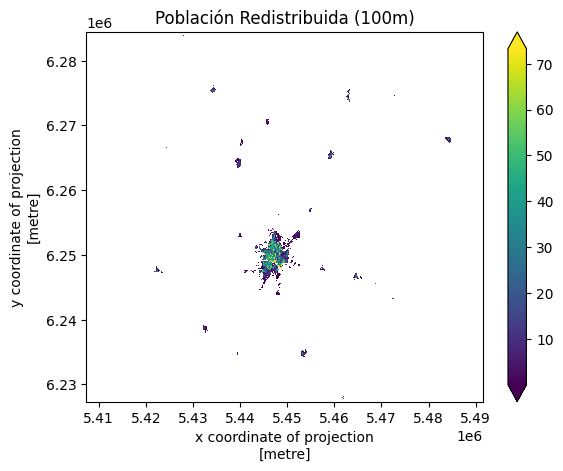

In [13]:
pob_redistribuida_enmascarada.plot(robust=True)
plt.title("Población Redistribuida (100m)")
plt.show()

In [14]:
print(f"Porcentaje de diferencia, GHSL y censo: {((float(ghsl_masked.sum().values) - total_censo) / total_censo) * 100:.2f}%")

Porcentaje de diferencia, GHSL y censo: 42.82%


In [15]:
from rasterstats import zonal_stats
import pandas as pd
import numpy as np

# Ensure aglomerados_urbanos is in the same CRS as rasters
aglom_reprojected = aglomerados_urbanos.to_crs(ghsl_masked.rio.crs)

# Calculate population sum for each classification from both rasters
stats_ghsl = zonal_stats(
    aglom_reprojected.geometry,
    ghsl_masked.squeeze().values,
    affine=ghsl_masked.rio.transform(),
    stats=['sum'],
    nodata=np.nan
)

stats_censo = zonal_stats(
    aglom_reprojected.geometry,
    pob_redistribuida_enmascarada.squeeze().values,
    affine=pob_redistribuida_enmascarada.rio.transform(),
    stats=['sum'],
    nodata=np.nan
)

# Add to dataframe
aglom_reprojected['pop_ghsl'] = [s['sum'] if s['sum'] is not None else 0 for s in stats_ghsl]
aglom_reprojected['pop_censo'] = [s['sum'] if s['sum'] is not None else 0 for s in stats_censo]

# Group by classification and sum
result = aglom_reprojected.groupby('clasificacion')[['pop_ghsl', 'pop_censo']].sum()
result.columns = ['GHSL 2025', 'Censo 2022']

# Add percentages
result['GHSL 2025 (%)'] = (result['GHSL 2025'] / result['GHSL 2025'].sum() * 100).round(1)
result['Censo 2022 (%)'] = (result['Censo 2022'] / result['Censo 2022'].sum() * 100).round(1)

result

GHSL 2025    Censo 2022  GHSL 2025 (%)  \
clasificacion                                                     
periurbana             5064.208374   3549.932327            3.1   
urbana               142610.975316  97687.199081           88.2   
urbano en ruralidad   13965.301045  10742.445090            8.6   

                     Censo 2022 (%)  
clasificacion                        
periurbana                      3.2  
urbana                         87.2  
urbano en ruralidad             9.6

### Vulnerabilidad

In [16]:
# Rasterizar proporciones de privación (porcentaje / 100)
raster_privacion = rasterize(
    [
        (geom, valor)
        for geom, valor in zip(gdf.geometry, gdf["porcentaje_privacion"] / 100)
    ],
    out_shape=forma_referencia,
    transform=transformacion_referencia,
    fill=0,
    dtype=np.float32,
    all_touched=True,
)

# Calcular población en privación
mascara_pob_privacion = (pob_redistribuida > 0) & (raster_privacion > 0)
pob_privacion = np.full_like(pob_redistribuida, 0, dtype=np.float64)
pob_privacion[mascara_pob_privacion] = (
    pob_redistribuida[mascara_pob_privacion] * raster_privacion[mascara_pob_privacion]
)

# convertir a DataArray y asignar CRS
pob_privacion_da = xr.DataArray(
    pob_privacion,
    coords={"y": ghsl_clipped.y, "x": ghsl_clipped.x},
    dims=["y", "x"],
)
pob_privacion_da = pob_privacion_da.rio.write_crs(USE_CRS)
pob_privacion_enmascarada = pob_privacion_da.where(pob_privacion_da > 0)

total_pob_privacion = pob_privacion[pob_privacion > 0].sum()
print(f"Población en privación: {total_pob_privacion:,.0f}")
print(f"Porcentaje del total: {(total_pob_privacion / total_redistribuido) * 100:.1f}%")

Población en privación: 36,181
Porcentaje del total: 31.7%


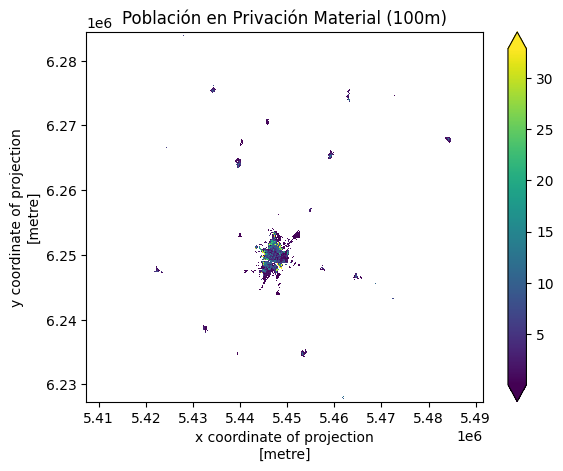

In [17]:
pob_privacion_enmascarada.plot(robust=True)
plt.title("Población en Privación Material (100m)")
plt.show()

In [ ]:
# total pop
# census downscaled pop
# report a range
# break it down into a table that contains min and max pop exposed by scenario and by area (urban, periurban, rural)
# get into what that means as a percentage--is there high or low exposure in these areas?
# then get into this specifically from the perspective of income--income versus mean + median LST with spearman's correlation (find out which is higher)

In [18]:
from rasterstats import zonal_stats
import pandas as pd
import numpy as np
import rasterio.enums

# Ensure same CRS
aglom_reprojected = aglomerados_urbanos.to_crs(LST_max_computed.rio.crs)

results = []

for urban_class in aglom_reprojected['clasificacion'].unique():
    # Get polygons for this urban classification
    class_mask = aglom_reprojected[aglom_reprojected['clasificacion'] == urban_class]
    
    # Get all LST values within this classification to calculate 75th percentile
    lst_values = []
    for geom in class_mask.geometry:
        stats = zonal_stats(
            [geom],
            LST_max_computed.squeeze().values,
            affine=LST_max_computed.rio.transform(),
            stats=['mean'],
            nodata=np.nan,
            raster_out=True
        )
        if stats[0]['mini_raster_array'] is not None:
            valid_vals = stats[0]['mini_raster_array'].compressed()
            lst_values.extend(valid_vals)
    
    # Calculate 75th percentile threshold
    threshold = np.percentile(lst_values, 75) if len(lst_values) > 0 else np.nan
    
    # Create hotspot mask at LST resolution
    hotspot_mask = (LST_max_computed >= threshold).astype(int)
    
    # Resample population rasters to 30m to match LST
    pob_30m = (
        pob_redistribuida_enmascarada.rio.reproject_match(
            LST_max_computed,
            resampling=rasterio.enums.Resampling.nearest,
        )
        / 11.1111
    )
    
    pob_privacion_30m = (
        pob_privacion_enmascarada.rio.reproject_match(
            LST_max_computed,
            resampling=rasterio.enums.Resampling.nearest,
        )
        / 11.1111
    )
    
    # Calculate total population and poverty population in this classification
    total_pop = sum([s['sum'] for s in zonal_stats(
        class_mask.geometry,
        pob_30m.squeeze().values,
        affine=pob_30m.rio.transform(),
        stats=['sum'],
        nodata=np.nan
    ) if s['sum'] is not None])
    
    total_pop_poverty = sum([s['sum'] for s in zonal_stats(
        class_mask.geometry,
        pob_privacion_30m.squeeze().values,
        affine=pob_privacion_30m.rio.transform(),
        stats=['sum'],
        nodata=np.nan
    ) if s['sum'] is not None])
    
    # Calculate exposed population (in hotspots)
    pop_exposed_array = pob_30m.squeeze().values * hotspot_mask.squeeze().values
    pop_exposed_stats = zonal_stats(
        class_mask.geometry,
        pop_exposed_array,
        affine=pob_30m.rio.transform(),
        stats=['sum'],
        nodata=np.nan
    )
    pop_exposed = sum([s['sum'] for s in pop_exposed_stats if s['sum'] is not None])
    
    # Calculate exposed poverty population (in hotspots)
    pop_poverty_exposed_array = pob_privacion_30m.squeeze().values * hotspot_mask.squeeze().values
    pop_poverty_exposed_stats = zonal_stats(
        class_mask.geometry,
        pop_poverty_exposed_array,
        affine=pob_privacion_30m.rio.transform(),
        stats=['sum'],
        nodata=np.nan
    )
    pop_poverty_exposed = sum([s['sum'] for s in pop_poverty_exposed_stats if s['sum'] is not None])
    
    results.append({
        'Clasificación': urban_class,
        'Población Expuesta': int(pop_exposed),
        '% Población Expuesta': round(pop_exposed / total_pop * 100, 1) if total_pop > 0 else 0,
        'Población en Privación Expuesta': int(pop_poverty_exposed),
        '% Población en Privación Expuesta': round(pop_poverty_exposed / total_pop_poverty * 100, 1) if total_pop_poverty > 0 else 0
    })

df_exposure = pd.DataFrame(results)
df_exposure

Clasificación  Población Expuesta  % Población Expuesta  \
0               urbana                8988                   9.1   
1           periurbana                 333                   9.3   
2  urbano en ruralidad                1166                  11.0   

   Población en Privación Expuesta  % Población en Privación Expuesta  
0                             3924                               13.0  
1                              200                               12.0  
2                              361                               10.2

In [19]:
# Create xarray DataArrays for the exposure layers (population ONLY in P75 hotspots)
exposed_pop_xr = pob_30m.copy()
exposed_pop_xr.values = pop_exposed_array  # Already masked to hotspots
exposed_pop_xr.name = "exposed_population"

exposed_vuln_pop_xr = pob_privacion_30m.copy()
exposed_vuln_pop_xr.values = pop_poverty_exposed_array  # Already masked to hotspots
exposed_vuln_pop_xr.name = "exposed_vulnerable_population"

# Write to GeoTIFF
exposed_pop_xr.rio.to_raster("exposed_pop.tif", compress="lzw")
exposed_vuln_pop_xr.rio.to_raster("exposed_vuln_pop.tif", compress="lzw")

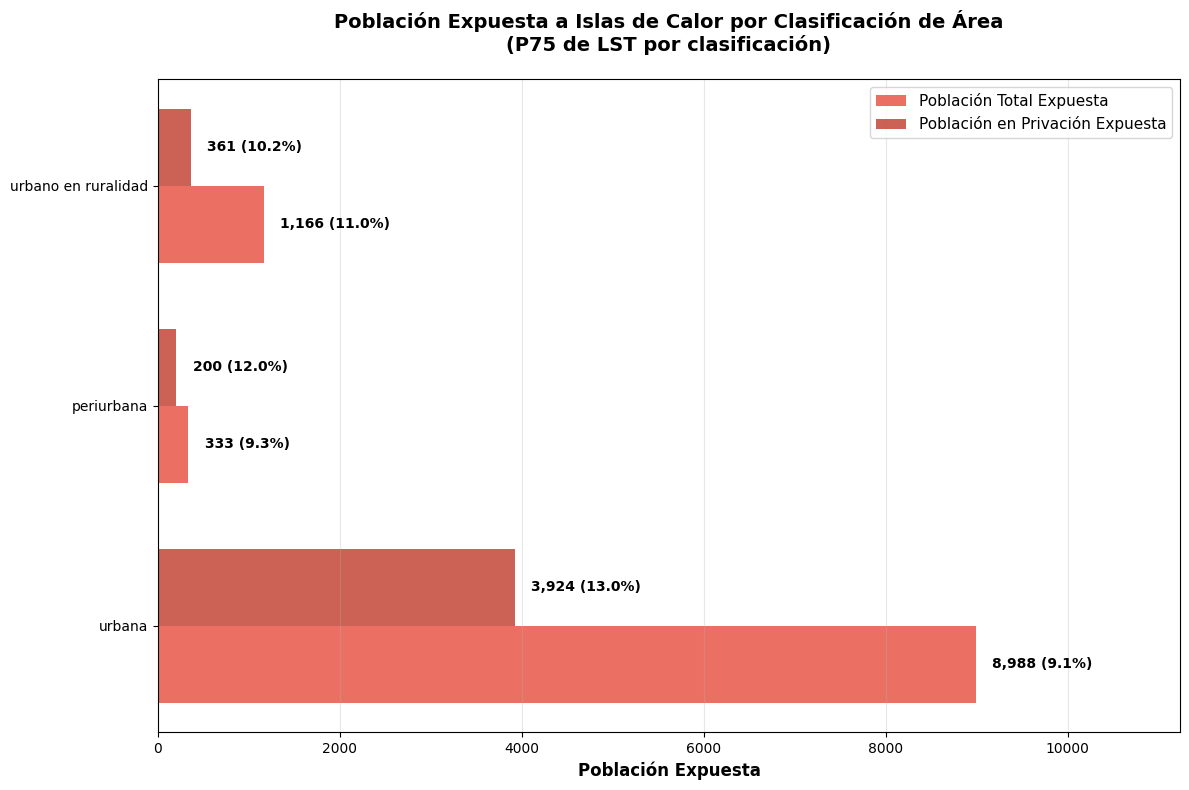

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
clasificaciones = df_exposure['Clasificación']
pop_exposed = df_exposure['Población Expuesta']
pop_exposed_pct = df_exposure['% Población Expuesta']
pop_poverty_exposed = df_exposure['Población en Privación Expuesta']
pop_poverty_exposed_pct = df_exposure['% Población en Privación Expuesta']

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

# Set up bar positions
y_pos = np.arange(len(clasificaciones))
bar_height = 0.35

# Create bars
bars1 = ax.barh(y_pos - bar_height/2, pop_exposed, bar_height, 
                label='Población Total Expuesta', color='#e74c3c', alpha=0.8)
bars2 = ax.barh(y_pos + bar_height/2, pop_poverty_exposed, bar_height, 
                label='Población en Privación Expuesta', color='#c0392b', alpha=0.8)

# Add labels with counts and percentages
for i, (bar, count, pct) in enumerate(zip(bars1, pop_exposed, pop_exposed_pct)):
    width = bar.get_width()
    ax.text(width + max(pop_exposed) * 0.02, bar.get_y() + bar.get_height()/2, 
            f'{int(count):,} ({pct}%)', 
            va='center', fontsize=10, fontweight='bold')

for i, (bar, count, pct) in enumerate(zip(bars2, pop_poverty_exposed, pop_poverty_exposed_pct)):
    width = bar.get_width()
    ax.text(width + max(pop_exposed) * 0.02, bar.get_y() + bar.get_height()/2, 
            f'{int(count):,} ({pct}%)', 
            va='center', fontsize=10, fontweight='bold')

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(clasificaciones)
ax.set_xlabel('Población Expuesta', fontsize=12, fontweight='bold')
ax.set_title('Población Expuesta a Islas de Calor por Clasificación de Área\n(P75 de LST por clasificación)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=11)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, max(pop_exposed) * 1.25)  # Extra space for labels

plt.tight_layout()
plt.savefig('pop_exp_by_zone_type_pergamino.svg', format='svg', bbox_inches='tight')
plt.show()

In [21]:
print("=" * 60)
print("ANÁLISIS DE INEQUIDAD POR CLASIFICACIÓN URBANA")
print("=" * 60)
print()

for _, row in df_exposure.iterrows():
    urban_class = row['Clasificación']
    
    # Get total populations for this class
    class_mask = aglom_reprojected[aglom_reprojected['clasificacion'] == urban_class]
    
    total_pop = sum([s['sum'] for s in zonal_stats(
        class_mask.geometry,
        pob_30m.squeeze().values,
        affine=pob_30m.rio.transform(),
        stats=['sum'],
        nodata=np.nan
    ) if s['sum'] is not None])
    
    total_pop_poverty = sum([s['sum'] for s in zonal_stats(
        class_mask.geometry,
        pob_privacion_30m.squeeze().values,
        affine=pob_privacion_30m.rio.transform(),
        stats=['sum'],
        nodata=np.nan
    ) if s['sum'] is not None])
    
    # Calculate percentages
    pct_poverty_of_total = (total_pop_poverty / total_pop * 100) if total_pop > 0 else 0
    pct_poverty_of_exposed = (row['Población en Privación Expuesta'] / row['Población Expuesta'] * 100) if row['Población Expuesta'] > 0 else 0
    
    print(f"{urban_class}:")
    print(f"  La población en privación representa el {pct_poverty_of_total:.1f}%")
    print(f"  de la población total, pero el {pct_poverty_of_exposed:.1f}%")
    print(f"  de la población expuesta al calor extremo.")
    
    if pct_poverty_of_exposed > pct_poverty_of_total:
        factor = pct_poverty_of_exposed / pct_poverty_of_total if pct_poverty_of_total > 0 else 0
        print(f"  → DESPROPORCIONADAMENTE expuestas ({factor:.2f}x más)")
    else:
        print(f"  → Exposición proporcional o menor")
    print()

print("=" * 60)

ANÁLISIS DE INEQUIDAD POR CLASIFICACIÓN URBANA

urbana:
  La población en privación representa el 30.6%
  de la población total, pero el 43.7%
  de la población expuesta al calor extremo.
  → DESPROPORCIONADAMENTE expuestas (1.43x más)

periurbana:
  La población en privación representa el 46.5%
  de la población total, pero el 60.1%
  de la población expuesta al calor extremo.
  → DESPROPORCIONADAMENTE expuestas (1.29x más)

urbano en ruralidad:
  La población en privación representa el 33.6%
  de la población total, pero el 31.0%
  de la población expuesta al calor extremo.
  → Exposición proporcional o menor



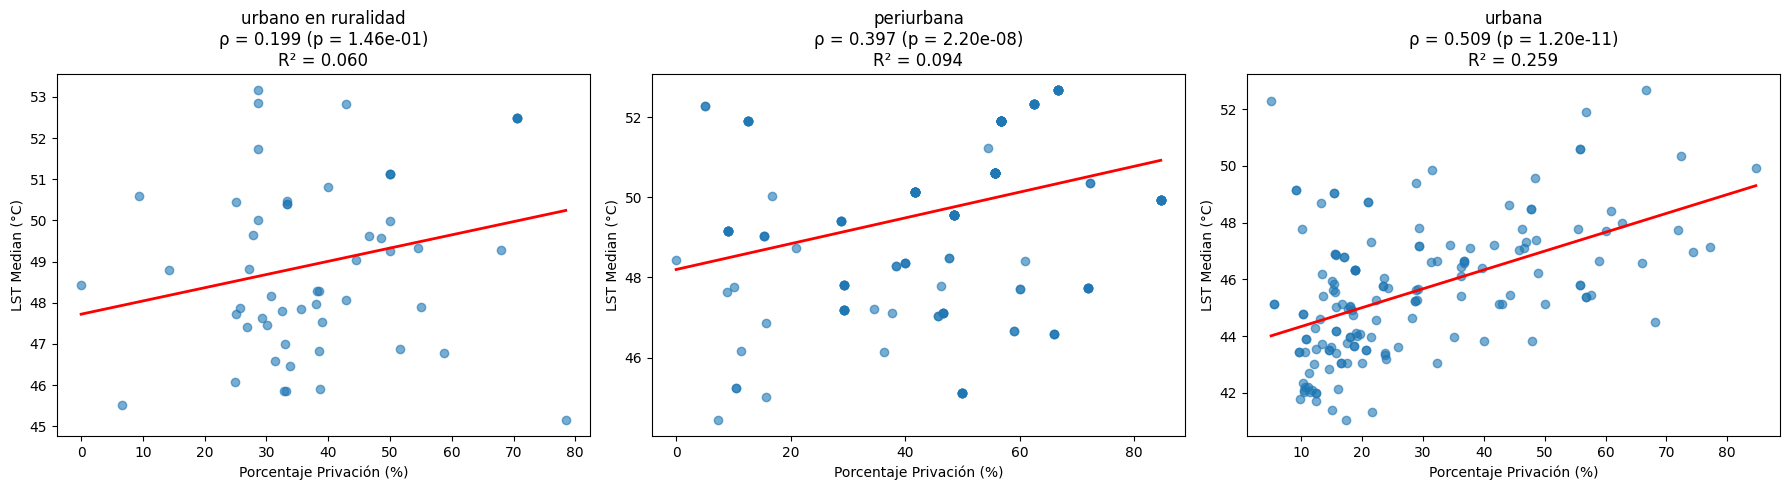

Correlaciones por clasificación:
urbano en ruralidad: ρ = 0.199 (p = 1.46e-01, n = 55)
periurbana: ρ = 0.397 (p = 2.20e-08, n = 185)
urbana: ρ = 0.509 (p = 1.20e-11, n = 156)


In [22]:
from rasterstats import zonal_stats
from scipy.stats import spearmanr, linregress
import numpy as np
import matplotlib.pyplot as plt

# Join census data with urban classification
gdf_reprojected = gdf.to_crs("EPSG:3857")
gdf_with_class = gpd.sjoin(gdf_reprojected, aglom_reprojected[['clasificacion', 'geometry']], how='inner', predicate='intersects')

# Calculate zonal stats for median
stats = zonal_stats(
    gdf_with_class.geometry, 
    LST_max_computed.squeeze().values,
    affine=LST_max_computed.rio.transform(),
    stats=['median'],
    nodata=np.nan
)

gdf_with_class['LST_median'] = [s['median'] if s['median'] is not None else np.nan for s in stats]
gdf_clean = gdf_with_class.dropna(subset=['LST_median', 'porcentaje_privacion'])

# Create faceted plot
classifications = gdf_clean['clasificacion'].unique()
n_classes = len(classifications)

fig, axes = plt.subplots(1, n_classes, figsize=(6*n_classes, 5))
if n_classes == 1:
    axes = [axes]

for idx, urban_class in enumerate(classifications):
    ax = axes[idx]
    data = gdf_clean[gdf_clean['clasificacion'] == urban_class]
    
    if len(data) < 3:
        ax.text(0.5, 0.5, f'Datos insuficientes\n({len(data)} tracts)', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(urban_class)
        continue
    
    x = data['porcentaje_privacion'].values
    y = data['LST_median'].values
    
    # Calculate correlation and fit
    corr, pval = spearmanr(x, y)
    slope, intercept, r_value, _, _ = linregress(x, y)
    
    # Plot
    ax.scatter(x, y, alpha=0.6)
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2)
    
    ax.set_xlabel('Porcentaje Privación (%)')
    ax.set_ylabel('LST Median (°C)')
    ax.set_title(f'{urban_class}\nρ = {corr:.3f} (p = {pval:.2e})\nR² = {r_value**2:.3f}')

plt.tight_layout()
plt.show()

# Print summary
print("Correlaciones por clasificación:")
for urban_class in classifications:
    data = gdf_clean[gdf_clean['clasificacion'] == urban_class]
    if len(data) >= 3:
        corr, pval = spearmanr(data['porcentaje_privacion'], data['LST_median'])
        print(f"{urban_class}: ρ = {corr:.3f} (p = {pval:.2e}, n = {len(data)})")

/tmp/ipykernel_25027/3675132475.py:38: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x_line, slope * x_line + intercept, 'k-', linewidth=2, linestyle='--')


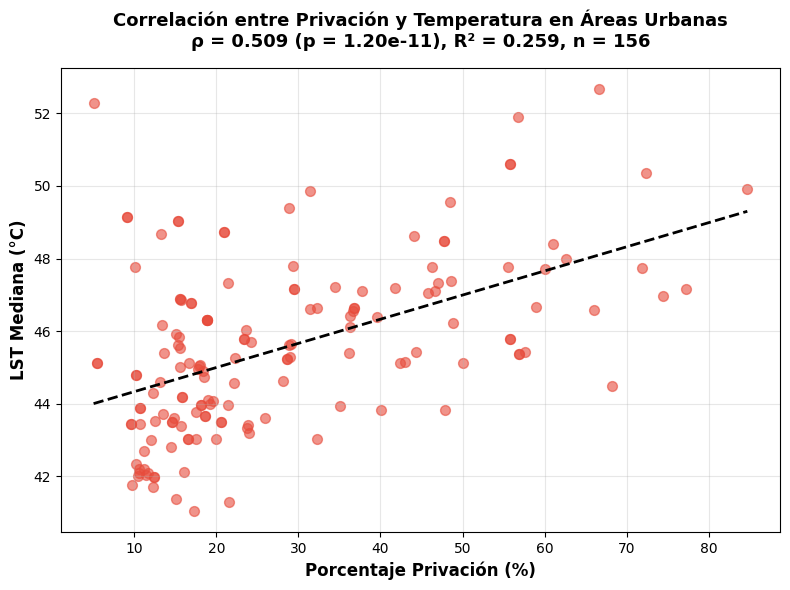

Correlación Spearman: ρ = 0.509
P-valor: 1.20e-11
R² lineal: 0.259
Número de tracts: 156


In [34]:
from rasterstats import zonal_stats
from scipy.stats import spearmanr, linregress
import numpy as np
import matplotlib.pyplot as plt

# Join census data with urban classification
gdf_reprojected = gdf.to_crs("EPSG:3857")
gdf_with_class = gpd.sjoin(gdf_reprojected, aglom_reprojected[['clasificacion', 'geometry']], how='inner', predicate='intersects')

# Filter for only urban tracts
gdf_urban = gdf_with_class[gdf_with_class['clasificacion'] == 'urbana'].copy()

# Calculate zonal stats for median
stats = zonal_stats(
    gdf_urban.geometry, 
    LST_max_computed.squeeze().values,
    affine=LST_max_computed.rio.transform(),
    stats=['median'],
    nodata=np.nan
)

gdf_urban['LST_median'] = [s['median'] if s['median'] is not None else np.nan for s in stats]
gdf_clean = gdf_urban.dropna(subset=['LST_median', 'porcentaje_privacion'])

# Create single plot
fig, ax = plt.subplots(figsize=(8, 6))

x = gdf_clean['porcentaje_privacion'].values
y = gdf_clean['LST_median'].values

# Calculate correlation and fit
corr, pval = spearmanr(x, y)
slope, intercept, r_value, _, _ = linregress(x, y)

# Plot
ax.scatter(x, y, alpha=0.6, s=50, color='#e74c3c')
x_line = np.linspace(x.min(), x.max(), 100)
ax.plot(x_line, slope * x_line + intercept, 'k-', linewidth=2, linestyle='--')

ax.set_xlabel('Porcentaje Privación (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('LST Mediana (°C)', fontsize=12, fontweight='bold')
ax.set_title(f'Correlación entre Privación y Temperatura en Áreas Urbanas\nρ = {corr:.3f} (p = {pval:.2e}), R² = {r_value**2:.3f}, n = {len(gdf_clean)}',
             fontsize=13, fontweight='bold', pad=15)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('lst_pov_corr_pergamino.svg', format='svg', bbox_inches='tight')
plt.show()

print(f"Correlación Spearman: ρ = {corr:.3f}")
print(f"P-valor: {pval:.2e}")
print(f"R² lineal: {r_value**2:.3f}")
print(f"Número de tracts: {len(gdf_clean)}")

### Resumen por barrio

In [26]:
layer_name = "publico:barrios"


params = {
    "service": "WFS",
    "version": "2.0.0",
    "request": "GetFeature",
    "typename": layer_name,
    "outputFormat": "application/json",
    "srsname": "EPSG:4326",
    "bbox": f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]},EPSG:4326",
}

response = requests.get(wfs_url, params=params)

if response.status_code == 200:
    barrios = gpd.read_file(BytesIO(response.content))
    print(f"Loaded {len(barrios)} barrio features")
    # print(f"CRS: {barrios.crs}")

    # Clip to exact Pergamino boundary
    barrios = barrios.to_crs(pergamino.crs)

else:
    print(f"Error: {response.status_code}")
    print(response.text)

Loaded 45 barrio features


In [27]:
aglom_reprojected = aglomerados_urbanos.to_crs(LST_max_computed.rio.crs)
barrios_reprojected = barrios.to_crs(LST_max_computed.rio.crs)

In [28]:
# Calculate exposure for each neighborhood using existing hotspot masks
results = []

for idx, barrio in barrios_reprojected.iterrows():
    barrio_geom = barrio.geometry
    barrio_name = barrio.get('nombre', barrio.get('name', f'Barrio_{idx}'))
    
    # Total population
    total_pop_stats = zonal_stats(
        [barrio_geom],
        pob_30m.squeeze().values,
        affine=pob_30m.rio.transform(),
        stats=['sum'],
        nodata=np.nan
    )
    total_pop = total_pop_stats[0]['sum'] if total_pop_stats[0]['sum'] is not None else 0
    
    # Total poverty population
    total_pop_poverty_stats = zonal_stats(
        [barrio_geom],
        pob_privacion_30m.squeeze().values,
        affine=pob_privacion_30m.rio.transform(),
        stats=['sum'],
        nodata=np.nan
    )
    total_pop_poverty = total_pop_poverty_stats[0]['sum'] if total_pop_poverty_stats[0]['sum'] is not None else 0
    
    # Exposed population (using existing hotspot_mask from the classification loop)
    pop_exposed_stats = zonal_stats(
        [barrio_geom],
        pop_exposed_array,
        affine=pob_30m.rio.transform(),
        stats=['sum'],
        nodata=np.nan
    )
    pop_exposed = pop_exposed_stats[0]['sum'] if pop_exposed_stats[0]['sum'] is not None else 0
    
    # Exposed poverty population
    pop_poverty_exposed_stats = zonal_stats(
        [barrio_geom],
        pop_poverty_exposed_array,
        affine=pob_privacion_30m.rio.transform(),
        stats=['sum'],
        nodata=np.nan
    )
    pop_poverty_exposed = pop_poverty_exposed_stats[0]['sum'] if pop_poverty_exposed_stats[0]['sum'] is not None else 0
    
    # Average LST
    lst_stats = zonal_stats(
        [barrio_geom],
        LST_max_computed.squeeze().values,
        affine=LST_max_computed.rio.transform(),
        stats=['mean', 'median'],
        nodata=np.nan
    )
    
    results.append({
        'Barrio': barrio_name,
        'Población Total': int(total_pop),
        'Población Expuesta': int(pop_exposed),
        '% Población Expuesta': round(pop_exposed / total_pop * 100, 1) if total_pop > 0 else 0,
        'Población en Privación': int(total_pop_poverty),
        'Población en Privación Expuesta': int(pop_poverty_exposed),
        '% Población en Privación Expuesta': round(pop_poverty_exposed / total_pop_poverty * 100, 1) if total_pop_poverty > 0 else 0,
        'LST Promedio': round(lst_stats[0]['mean'], 1) if lst_stats[0]['mean'] is not None else np.nan,
        'LST Mediana': round(lst_stats[0]['median'], 1) if lst_stats[0]['median'] is not None else np.nan
    })

df_barrios_exposure = pd.DataFrame(results)
df_barrios_exposure_sorted = df_barrios_exposure.sort_values('Población Expuesta', ascending=False)

df_barrios_exposure_sorted.head(10)

Barrio  Población Total  Población Expuesta  \
25        Martín Illia             4556                 607   
2           Santa Inés              714                 452   
32       12 de Octubre             3022                 436   
38            Malvinas             2654                 290   
1              Kennedy             2202                 251   
19       René Favaloro              493                 179   
42  Atahualpa Yupanqui             1559                 153   
9           Champagnat             1157                 150   
7       Villa San José             6080                 143   
11  Quinta Mastrángelo              558                 143   

    % Población Expuesta  Población en Privación  \
25                  13.3                    1480   
2                   63.3                     528   
32                  14.4                    1859   
38                  10.9                     720   
1                   11.4                    1506   
19                  36.5                     275   
42                   9.8                     202   
9                   13.0                     331   
7                    2.4                    2325   
11                  25.6                     460   

    Población en Privación Expuesta  % Población en Privación Expuesta  \
25                              314                               21.3   
2                               358                               67.9   
32                              314                               16.9   
38                               82                               11.5   
1                               157                               10.5   
19                              100                               36.6   
42                               27                               13.6   
9                                43                               13.3   
7                                68                                3.0   
11                              110                               24.1   

    LST Promedio  LST Mediana  
25          47.6         47.5  
2           51.6         51.4  
32          50.2         50.1  
38          48.0         48.0  
1           47.9         47.9  
19          53.4         53.5  
42          47.7         47.6  
9           51.8         52.1  
7           47.2         47.0  
11          50.6         50.5

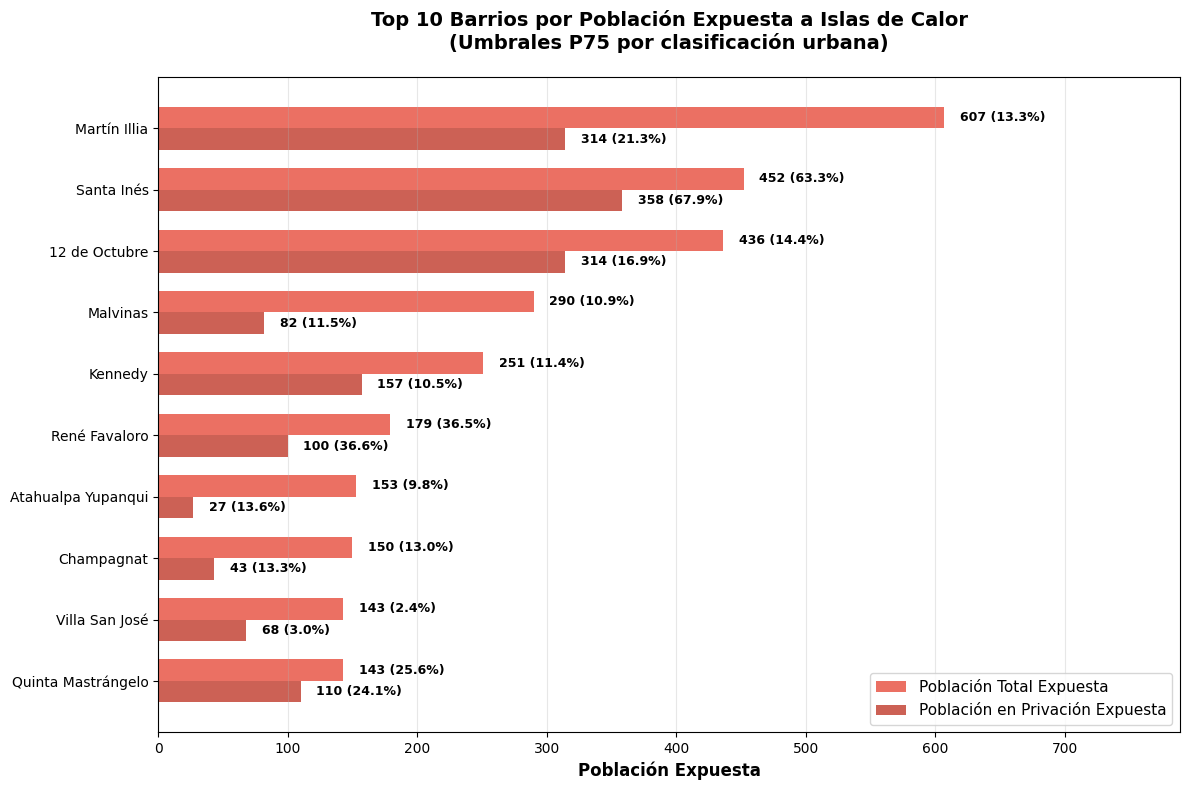

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Get top 10 by total population exposed
top_10 = df_barrios_exposure_sorted.head(10)

# Prepare data
barrios = top_10['Barrio']
pop_exposed = top_10['Población Expuesta']
pop_exposed_pct = top_10['% Población Expuesta']
pop_poverty_exposed = top_10['Población en Privación Expuesta']
pop_poverty_exposed_pct = top_10['% Población en Privación Expuesta']

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

# Set up bar positions
y_pos = np.arange(len(barrios))
bar_height = 0.35

# Create bars (reversed order for top-to-bottom display)
bars1 = ax.barh(y_pos + bar_height/2, pop_exposed[::-1], bar_height, 
                label='Población Total Expuesta', color='#e74c3c', alpha=0.8)
bars2 = ax.barh(y_pos - bar_height/2, pop_poverty_exposed[::-1], bar_height, 
                label='Población en Privación Expuesta', color='#c0392b', alpha=0.8)

# Add labels with counts and percentages
for i, (bar, count, pct) in enumerate(zip(bars1, pop_exposed[::-1], pop_exposed_pct[::-1])):
    width = bar.get_width()
    ax.text(width + max(pop_exposed) * 0.02, bar.get_y() + bar.get_height()/2, 
            f'{int(count):,} ({pct}%)', 
            va='center', fontsize=9, fontweight='bold')

for i, (bar, count, pct) in enumerate(zip(bars2, pop_poverty_exposed[::-1], pop_poverty_exposed_pct[::-1])):
    width = bar.get_width()
    ax.text(width + max(pop_exposed) * 0.02, bar.get_y() + bar.get_height()/2, 
            f'{int(count):,} ({pct}%)', 
            va='center', fontsize=9, fontweight='bold')

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(barrios[::-1])
ax.set_xlabel('Población Expuesta', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Barrios por Población Expuesta a Islas de Calor\n(Umbrales P75 por clasificación urbana)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=11)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, max(pop_exposed) * 1.3)

plt.tight_layout()
plt.savefig('lst_by_neighborhood_pergamino.svg', format='svg', bbox_inches='tight')
plt.show()

## Proposed interventions